<a href="https://colab.research.google.com/github/ryangandi46/asr_wav2vav2_whisper/blob/main/whisper_vs_wav2vec2_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jalankan sekali di Colab
!pip install -q transformers datasets torchaudio accelerate jiwer psutil GPUtil librosa noisereduce soundfile unidecode

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.8 MB/s eta 0:00:00


In [ ]:
pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
import torch
import time
import psutil
import GPUtil
import librosa
import numpy as np
from jiwer import wer
from datasets import load_dataset
from transformers import (
    AutoModelForSpeechSeq2Seq, AutoProcessor,
    AutoModelForCTC, Wav2Vec2Processor,
    pipeline
)
import os
import noisereduce as nr
import soundfile as sf
import re
import unidecode
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Set cache directory
os.environ["HF_DATASETS_CACHE"] = "/content/hf_cache"

# Device & dtype
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# load model

In [ ]:
from transformers import pipeline

whisper_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=device  # gunakan -1 jika hanya CPU
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Load Wav2Vec2
w2v2_id = "cahya/wav2vec2-large-xlsr-indonesian"
# w2v2_id = "facebook/wav2vec2-large-xlsr-53"
# w2v2_id = "facebook/wav2vec2-base-960h"
# w2v2_id = "indonesian-nlp/wav2vec2-indonesian-javanese-sundanese"
w2v2_model = AutoModelForCTC.from_pretrained(w2v2_id).to(device)
w2v2_proc = Wav2Vec2Processor.from_pretrained(w2v2_id)
w2v2_pipe = pipeline(
    "automatic-speech-recognition",
    model=w2v2_model,
    tokenizer=w2v2_proc.tokenizer,
    feature_extractor=w2v2_proc.feature_extractor,
    device=device,
)

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Device set to use cuda:0


# cleaning data

In [ ]:
from google.colab import drive
import shutil

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Path Folder Lokal dan Drive ===
LOCAL_CLEANED_AUDIO = "/content/cleaned_audio"
GDRIVE_CLEANED_AUDIO = "/content/drive/MyDrive/skripsi ryan/cleaned_audio"

# Buat folder lokal dan di Drive jika belum ada
os.makedirs(LOCAL_CLEANED_AUDIO, exist_ok=True)
os.makedirs(GDRIVE_CLEANED_AUDIO, exist_ok=True)

# === Fungsi Preprocessing Audio ===
def preprocess_audio_clip(array, sr, save_path):
    if sr != 16000:
        array = librosa.resample(array, orig_sr=sr, target_sr=16000)
        sr = 16000
    array = array / max(1e-5, abs(array).max())
    array = nr.reduce_noise(y=array, sr=sr)
    sf.write(save_path, array, sr)
    return save_path

# === Fungsi Preprocessing Teks ===
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = unidecode.unidecode(text)
    return text

# === Salin semua audio hasil cleaning ke Google Drive ===
def copy_cleaned_audio_to_drive(src_folder, dst_folder):
    for fname in os.listdir(src_folder):
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(dst_folder, fname)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)
    print(f"✅ Semua file berhasil disalin ke {dst_folder}")

# Jalankan fungsi penyalinan
copy_cleaned_audio_to_drive(LOCAL_CLEANED_AUDIO, GDRIVE_CLEANED_AUDIO)

Mounted at /content/drive
✅ Semua file berhasil disalin ke /content/drive/MyDrive/skripsi ryan/cleaned_audio


In [ ]:
from datasets import load_dataset, Audio
from tqdm import tqdm
import os
import pandas as pd
import json # Import the json module here


# Load dataset Common Voice Indonesia (contoh 5%)
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "id", split="test[:5%]")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Output audio dan data directory
CLEAN_AUDIO_DIR = "/content/drive/MyDrive/skripsi ryan/cleaned_audio"
CLEANED_OUTPUT_PATH = "/content/drive/MyDrive/skripsi ryan/cleaned_data.json"

# Pastikan direktori audio ada
os.makedirs(CLEAN_AUDIO_DIR, exist_ok=True)

cleaned_data = []

for idx, sample in enumerate(tqdm(dataset)):
    try:
        audio = sample["audio"]
        text = sample["sentence"]
        array = audio["array"]
        sr = audio["sampling_rate"]

        if not array.any():
            print(f"\u274c Sample {idx} audio kosong, dilewati.")
            continue

        duration = len(array) / sr

        # Simpan audio hasil cleaning
        audio_path = os.path.join(CLEAN_AUDIO_DIR, f"cleaned_{idx}.wav")
        cleaned_audio_path = preprocess_audio_clip(array, sr, audio_path)

        # Cleaning teks
        cleaned_text = preprocess_text(text)

        cleaned_data.append({
            "path": cleaned_audio_path,
            "text": cleaned_text,
            "duration": duration,
            "age": sample.get("age", None),
            "gender": sample.get("gender", None),
            "accent": sample.get("accent", None)
        })

        print(f"\u2705 Sample {idx} berhasil diproses/disimpan")

    except Exception as e:
        print(f"Skip sample {idx}: {e}")

# Simpan sebagai JSON array (valid JSONB format)
with open(CLEANED_OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=2)

print(f"\n📁 Dataset berhasil disimpan sebagai JSON di {CLEANED_OUTPUT_PATH}")

README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

common_voice_11_0.py:   0%|          | 0.00/8.13k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


n_shards.json:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

audio/id/train/id_train_0.tar:   0%|          | 0.00/173M [00:00<?, ?B/s]

audio/id/dev/id_dev_0.tar:   0%|          | 0.00/100M [00:00<?, ?B/s]

audio/id/test/id_test_0.tar:   0%|          | 0.00/114M [00:00<?, ?B/s]

audio/id/other/id_other_0.tar:   0%|          | 0.00/568M [00:00<?, ?B/s]

audio/id/invalidated/id_invalidated_0.ta(…):   0%|          | 0.00/64.7M [00:00<?, ?B/s]

transcript/id/train.tsv:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

transcript/id/dev.tsv:   0%|          | 0.00/727k [00:00<?, ?B/s]

transcript/id/test.tsv:   0%|          | 0.00/783k [00:00<?, ?B/s]

transcript/id/other.tsv:   0%|          | 0.00/5.24M [00:00<?, ?B/s]

transcript/id/invalidated.tsv:   0%|          | 0.00/557k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 5048it [00:00, 112813.55it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 3226it [00:00, 106174.08it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 3618it [00:00, 119840.10it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 24238it [00:00, 159805.99it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 2466it [00:00, 96382.15it/s]
  1%|          | 1/181 [00:15<46:15, 15.42s/it]

✅ Sample 0 berhasil diproses/disimpan


  1%|          | 2/181 [00:16<20:09,  6.76s/it]

✅ Sample 1 berhasil diproses/disimpan


  2%|▏         | 3/181 [00:16<11:47,  3.97s/it]

✅ Sample 2 berhasil diproses/disimpan


  2%|▏         | 4/181 [00:17<07:53,  2.68s/it]

✅ Sample 3 berhasil diproses/disimpan


  3%|▎         | 5/181 [00:18<05:41,  1.94s/it]

✅ Sample 4 berhasil diproses/disimpan


  3%|▎         | 6/181 [00:18<04:24,  1.51s/it]

✅ Sample 5 berhasil diproses/disimpan


  4%|▍         | 7/181 [00:19<03:35,  1.24s/it]

✅ Sample 6 berhasil diproses/disimpan


  4%|▍         | 8/181 [00:20<03:03,  1.06s/it]

✅ Sample 7 berhasil diproses/disimpan


  5%|▍         | 9/181 [00:20<02:40,  1.07it/s]

✅ Sample 8 berhasil diproses/disimpan


  6%|▌         | 10/181 [00:21<02:33,  1.11it/s]

✅ Sample 9 berhasil diproses/disimpan


  6%|▌         | 11/181 [00:22<02:28,  1.14it/s]

✅ Sample 10 berhasil diproses/disimpan


  7%|▋         | 12/181 [00:23<02:17,  1.23it/s]

✅ Sample 11 berhasil diproses/disimpan


  7%|▋         | 13/181 [00:23<02:18,  1.21it/s]

✅ Sample 12 berhasil diproses/disimpan


  8%|▊         | 14/181 [00:24<02:10,  1.28it/s]

✅ Sample 13 berhasil diproses/disimpan


  8%|▊         | 15/181 [00:25<02:01,  1.36it/s]

✅ Sample 14 berhasil diproses/disimpan


  9%|▉         | 16/181 [00:26<02:16,  1.21it/s]

✅ Sample 15 berhasil diproses/disimpan


  9%|▉         | 17/181 [00:27<02:09,  1.26it/s]

✅ Sample 16 berhasil diproses/disimpan


 10%|▉         | 18/181 [00:27<02:05,  1.30it/s]

✅ Sample 17 berhasil diproses/disimpan


 10%|█         | 19/181 [00:28<01:57,  1.38it/s]

✅ Sample 18 berhasil diproses/disimpan


 11%|█         | 20/181 [00:29<01:55,  1.39it/s]

✅ Sample 19 berhasil diproses/disimpan


 12%|█▏        | 21/181 [00:29<02:04,  1.28it/s]

✅ Sample 20 berhasil diproses/disimpan


 12%|█▏        | 22/181 [00:30<02:03,  1.28it/s]

✅ Sample 21 berhasil diproses/disimpan


 13%|█▎        | 23/181 [00:31<01:57,  1.34it/s]

✅ Sample 22 berhasil diproses/disimpan


 13%|█▎        | 24/181 [00:32<02:13,  1.18it/s]

✅ Sample 23 berhasil diproses/disimpan


 14%|█▍        | 25/181 [00:33<02:06,  1.23it/s]

✅ Sample 24 berhasil diproses/disimpan


 14%|█▍        | 26/181 [00:34<02:12,  1.17it/s]

✅ Sample 25 berhasil diproses/disimpan


 15%|█▍        | 27/181 [00:34<02:08,  1.20it/s]

✅ Sample 26 berhasil diproses/disimpan


 15%|█▌        | 28/181 [00:35<02:08,  1.20it/s]

✅ Sample 27 berhasil diproses/disimpan


 16%|█▌        | 29/181 [00:37<02:43,  1.08s/it]

✅ Sample 28 berhasil diproses/disimpan


 17%|█▋        | 30/181 [00:38<02:24,  1.05it/s]

✅ Sample 29 berhasil diproses/disimpan


 17%|█▋        | 31/181 [00:38<02:11,  1.14it/s]

✅ Sample 30 berhasil diproses/disimpan


 18%|█▊        | 32/181 [00:39<02:02,  1.21it/s]

✅ Sample 31 berhasil diproses/disimpan


 18%|█▊        | 33/181 [00:40<01:56,  1.27it/s]

✅ Sample 32 berhasil diproses/disimpan


 19%|█▉        | 34/181 [00:41<02:06,  1.17it/s]

✅ Sample 33 berhasil diproses/disimpan


 19%|█▉        | 35/181 [00:41<01:57,  1.25it/s]

✅ Sample 34 berhasil diproses/disimpan


 20%|█▉        | 36/181 [00:42<01:51,  1.30it/s]

✅ Sample 35 berhasil diproses/disimpan


 20%|██        | 37/181 [00:43<01:49,  1.32it/s]

✅ Sample 36 berhasil diproses/disimpan


 21%|██        | 38/181 [00:44<01:53,  1.26it/s]

✅ Sample 37 berhasil diproses/disimpan


 22%|██▏       | 39/181 [00:44<01:45,  1.34it/s]

✅ Sample 38 berhasil diproses/disimpan


 22%|██▏       | 40/181 [00:45<01:39,  1.41it/s]

✅ Sample 39 berhasil diproses/disimpan


 23%|██▎       | 41/181 [00:46<01:51,  1.26it/s]

✅ Sample 40 berhasil diproses/disimpan


 23%|██▎       | 42/181 [00:47<01:43,  1.35it/s]

✅ Sample 41 berhasil diproses/disimpan


 24%|██▍       | 43/181 [00:48<02:07,  1.08it/s]

✅ Sample 42 berhasil diproses/disimpan


 24%|██▍       | 44/181 [00:49<02:03,  1.11it/s]

✅ Sample 43 berhasil diproses/disimpan


 25%|██▍       | 45/181 [00:50<01:58,  1.15it/s]

✅ Sample 44 berhasil diproses/disimpan


 25%|██▌       | 46/181 [00:50<01:49,  1.23it/s]

✅ Sample 45 berhasil diproses/disimpan


 26%|██▌       | 47/181 [00:51<01:46,  1.26it/s]

✅ Sample 46 berhasil diproses/disimpan


 27%|██▋       | 48/181 [00:52<01:41,  1.31it/s]

✅ Sample 47 berhasil diproses/disimpan


 27%|██▋       | 49/181 [00:53<01:51,  1.18it/s]

✅ Sample 48 berhasil diproses/disimpan


 28%|██▊       | 50/181 [00:53<01:41,  1.29it/s]

✅ Sample 49 berhasil diproses/disimpan


 28%|██▊       | 51/181 [00:54<01:35,  1.36it/s]

✅ Sample 50 berhasil diproses/disimpan


 29%|██▊       | 52/181 [00:55<01:34,  1.37it/s]

✅ Sample 51 berhasil diproses/disimpan


 29%|██▉       | 53/181 [00:55<01:32,  1.38it/s]

✅ Sample 52 berhasil diproses/disimpan


 30%|██▉       | 54/181 [00:56<01:35,  1.33it/s]

✅ Sample 53 berhasil diproses/disimpan


 30%|███       | 55/181 [00:57<01:31,  1.38it/s]

✅ Sample 54 berhasil diproses/disimpan


 31%|███       | 56/181 [00:59<02:05,  1.00s/it]

✅ Sample 55 berhasil diproses/disimpan


 31%|███▏      | 57/181 [00:59<01:49,  1.13it/s]

✅ Sample 56 berhasil diproses/disimpan


 32%|███▏      | 58/181 [01:00<01:41,  1.21it/s]

✅ Sample 57 berhasil diproses/disimpan


 33%|███▎      | 59/181 [01:00<01:33,  1.30it/s]

✅ Sample 58 berhasil diproses/disimpan


 33%|███▎      | 60/181 [01:01<01:27,  1.38it/s]

✅ Sample 59 berhasil diproses/disimpan


 34%|███▎      | 61/181 [01:02<01:26,  1.39it/s]

✅ Sample 60 berhasil diproses/disimpan


 34%|███▍      | 62/181 [01:02<01:23,  1.42it/s]

✅ Sample 61 berhasil diproses/disimpan


 35%|███▍      | 63/181 [01:03<01:21,  1.44it/s]

✅ Sample 62 berhasil diproses/disimpan


 35%|███▌      | 64/181 [01:04<01:20,  1.46it/s]

✅ Sample 63 berhasil diproses/disimpan


 36%|███▌      | 65/181 [01:04<01:16,  1.52it/s]

✅ Sample 64 berhasil diproses/disimpan


 36%|███▋      | 66/181 [01:05<01:15,  1.53it/s]

✅ Sample 65 berhasil diproses/disimpan


 37%|███▋      | 67/181 [01:06<01:14,  1.53it/s]

✅ Sample 66 berhasil diproses/disimpan


 38%|███▊      | 68/181 [01:06<01:12,  1.56it/s]

✅ Sample 67 berhasil diproses/disimpan


 38%|███▊      | 69/181 [01:07<01:11,  1.57it/s]

✅ Sample 68 berhasil diproses/disimpan


 39%|███▊      | 70/181 [01:08<01:13,  1.52it/s]

✅ Sample 69 berhasil diproses/disimpan


 39%|███▉      | 71/181 [01:09<01:20,  1.36it/s]

✅ Sample 70 berhasil diproses/disimpan


 40%|███▉      | 72/181 [01:09<01:21,  1.35it/s]

✅ Sample 71 berhasil diproses/disimpan


 40%|████      | 73/181 [01:10<01:18,  1.37it/s]

✅ Sample 72 berhasil diproses/disimpan


 41%|████      | 74/181 [01:11<01:25,  1.26it/s]

✅ Sample 73 berhasil diproses/disimpan


 41%|████▏     | 75/181 [01:12<01:18,  1.35it/s]

✅ Sample 74 berhasil diproses/disimpan


 42%|████▏     | 76/181 [01:12<01:14,  1.42it/s]

✅ Sample 75 berhasil diproses/disimpan


 43%|████▎     | 77/181 [01:13<01:10,  1.48it/s]

✅ Sample 76 berhasil diproses/disimpan


 43%|████▎     | 78/181 [01:14<01:10,  1.46it/s]

✅ Sample 77 berhasil diproses/disimpan


 44%|████▎     | 79/181 [01:14<01:09,  1.47it/s]

✅ Sample 78 berhasil diproses/disimpan


 44%|████▍     | 80/181 [01:15<01:15,  1.34it/s]

✅ Sample 79 berhasil diproses/disimpan


 45%|████▍     | 81/181 [01:16<01:15,  1.32it/s]

✅ Sample 80 berhasil diproses/disimpan


 45%|████▌     | 82/181 [01:17<01:12,  1.37it/s]

✅ Sample 81 berhasil diproses/disimpan


 46%|████▌     | 83/181 [01:17<01:08,  1.43it/s]

✅ Sample 82 berhasil diproses/disimpan


 46%|████▋     | 84/181 [01:18<01:06,  1.45it/s]

✅ Sample 83 berhasil diproses/disimpan


 47%|████▋     | 85/181 [01:19<01:06,  1.44it/s]

✅ Sample 84 berhasil diproses/disimpan


 48%|████▊     | 86/181 [01:19<01:03,  1.49it/s]

✅ Sample 85 berhasil diproses/disimpan


 48%|████▊     | 87/181 [01:20<01:02,  1.51it/s]

✅ Sample 86 berhasil diproses/disimpan


 49%|████▊     | 88/181 [01:20<01:01,  1.52it/s]

✅ Sample 87 berhasil diproses/disimpan


 49%|████▉     | 89/181 [01:21<00:59,  1.55it/s]

✅ Sample 88 berhasil diproses/disimpan


 50%|████▉     | 90/181 [01:22<00:59,  1.54it/s]

✅ Sample 89 berhasil diproses/disimpan


 50%|█████     | 91/181 [01:22<00:58,  1.55it/s]

✅ Sample 90 berhasil diproses/disimpan


 51%|█████     | 92/181 [01:23<00:57,  1.55it/s]

✅ Sample 91 berhasil diproses/disimpan


 51%|█████▏    | 93/181 [01:24<00:56,  1.55it/s]

✅ Sample 92 berhasil diproses/disimpan


 52%|█████▏    | 94/181 [01:24<00:59,  1.45it/s]

✅ Sample 93 berhasil diproses/disimpan


 52%|█████▏    | 95/181 [01:25<00:57,  1.49it/s]

✅ Sample 94 berhasil diproses/disimpan


 53%|█████▎    | 96/181 [01:26<00:58,  1.45it/s]

✅ Sample 95 berhasil diproses/disimpan


 54%|█████▎    | 97/181 [01:26<00:57,  1.46it/s]

✅ Sample 96 berhasil diproses/disimpan


 54%|█████▍    | 98/181 [01:27<00:55,  1.49it/s]

✅ Sample 97 berhasil diproses/disimpan


 55%|█████▍    | 99/181 [01:28<00:53,  1.53it/s]

✅ Sample 98 berhasil diproses/disimpan


 55%|█████▌    | 100/181 [01:29<01:00,  1.33it/s]

✅ Sample 99 berhasil diproses/disimpan


 56%|█████▌    | 101/181 [01:29<00:57,  1.38it/s]

✅ Sample 100 berhasil diproses/disimpan


 56%|█████▋    | 102/181 [01:30<00:54,  1.45it/s]

✅ Sample 101 berhasil diproses/disimpan


 57%|█████▋    | 103/181 [01:31<00:53,  1.45it/s]

✅ Sample 102 berhasil diproses/disimpan


 57%|█████▋    | 104/181 [01:31<00:51,  1.50it/s]

✅ Sample 103 berhasil diproses/disimpan


 58%|█████▊    | 105/181 [01:32<00:54,  1.41it/s]

✅ Sample 104 berhasil diproses/disimpan


 59%|█████▊    | 106/181 [01:33<00:51,  1.47it/s]

✅ Sample 105 berhasil diproses/disimpan


 59%|█████▉    | 107/181 [01:33<00:49,  1.48it/s]

✅ Sample 106 berhasil diproses/disimpan


 60%|█████▉    | 108/181 [01:34<00:48,  1.51it/s]

✅ Sample 107 berhasil diproses/disimpan


 60%|██████    | 109/181 [01:35<00:53,  1.34it/s]

✅ Sample 108 berhasil diproses/disimpan


 61%|██████    | 110/181 [01:36<00:53,  1.32it/s]

✅ Sample 109 berhasil diproses/disimpan


 61%|██████▏   | 111/181 [01:36<00:51,  1.36it/s]

✅ Sample 110 berhasil diproses/disimpan


 62%|██████▏   | 112/181 [01:37<00:49,  1.39it/s]

✅ Sample 111 berhasil diproses/disimpan


 62%|██████▏   | 113/181 [01:38<00:48,  1.42it/s]

✅ Sample 112 berhasil diproses/disimpan


 63%|██████▎   | 114/181 [01:39<00:50,  1.34it/s]

✅ Sample 113 berhasil diproses/disimpan


 64%|██████▎   | 115/181 [01:39<00:47,  1.38it/s]

✅ Sample 114 berhasil diproses/disimpan


 64%|██████▍   | 116/181 [01:40<00:46,  1.39it/s]

✅ Sample 115 berhasil diproses/disimpan


 65%|██████▍   | 117/181 [01:41<00:43,  1.46it/s]

✅ Sample 116 berhasil diproses/disimpan


 65%|██████▌   | 118/181 [01:41<00:42,  1.49it/s]

✅ Sample 117 berhasil diproses/disimpan


 66%|██████▌   | 119/181 [01:42<00:40,  1.52it/s]

✅ Sample 118 berhasil diproses/disimpan


 66%|██████▋   | 120/181 [01:43<00:39,  1.54it/s]

✅ Sample 119 berhasil diproses/disimpan


 67%|██████▋   | 121/181 [01:43<00:40,  1.49it/s]

✅ Sample 120 berhasil diproses/disimpan


 67%|██████▋   | 122/181 [01:44<00:44,  1.32it/s]

✅ Sample 121 berhasil diproses/disimpan


 68%|██████▊   | 123/181 [01:45<00:43,  1.32it/s]

✅ Sample 122 berhasil diproses/disimpan


 69%|██████▊   | 124/181 [01:46<00:41,  1.36it/s]

✅ Sample 123 berhasil diproses/disimpan


 69%|██████▉   | 125/181 [01:46<00:40,  1.40it/s]

✅ Sample 124 berhasil diproses/disimpan


 70%|██████▉   | 126/181 [01:47<00:37,  1.47it/s]

✅ Sample 125 berhasil diproses/disimpan


 70%|███████   | 127/181 [01:48<00:36,  1.47it/s]

✅ Sample 126 berhasil diproses/disimpan


 71%|███████   | 128/181 [01:48<00:36,  1.44it/s]

✅ Sample 127 berhasil diproses/disimpan


 71%|███████▏  | 129/181 [01:49<00:35,  1.46it/s]

✅ Sample 128 berhasil diproses/disimpan


 72%|███████▏  | 130/181 [01:50<00:34,  1.48it/s]

✅ Sample 129 berhasil diproses/disimpan


 72%|███████▏  | 131/181 [01:50<00:34,  1.45it/s]

✅ Sample 130 berhasil diproses/disimpan


 73%|███████▎  | 132/181 [01:51<00:33,  1.48it/s]

✅ Sample 131 berhasil diproses/disimpan


 73%|███████▎  | 133/181 [01:52<00:32,  1.49it/s]

✅ Sample 132 berhasil diproses/disimpan


 74%|███████▍  | 134/181 [01:52<00:31,  1.48it/s]

✅ Sample 133 berhasil diproses/disimpan


 75%|███████▍  | 135/181 [01:53<00:31,  1.45it/s]

✅ Sample 134 berhasil diproses/disimpan


 75%|███████▌  | 136/181 [01:54<00:32,  1.39it/s]

✅ Sample 135 berhasil diproses/disimpan


 76%|███████▌  | 137/181 [01:54<00:30,  1.44it/s]

✅ Sample 136 berhasil diproses/disimpan


 76%|███████▌  | 138/181 [01:55<00:31,  1.38it/s]

✅ Sample 137 berhasil diproses/disimpan


 77%|███████▋  | 139/181 [01:56<00:30,  1.39it/s]

✅ Sample 138 berhasil diproses/disimpan


 77%|███████▋  | 140/181 [01:57<00:29,  1.40it/s]

✅ Sample 139 berhasil diproses/disimpan


 78%|███████▊  | 141/181 [01:57<00:28,  1.42it/s]

✅ Sample 140 berhasil diproses/disimpan


 78%|███████▊  | 142/181 [01:58<00:26,  1.45it/s]

✅ Sample 141 berhasil diproses/disimpan


 79%|███████▉  | 143/181 [01:59<00:26,  1.45it/s]

✅ Sample 142 berhasil diproses/disimpan


 80%|███████▉  | 144/181 [02:00<00:28,  1.29it/s]

✅ Sample 143 berhasil diproses/disimpan


 80%|████████  | 145/181 [02:00<00:26,  1.35it/s]

✅ Sample 144 berhasil diproses/disimpan


 81%|████████  | 146/181 [02:01<00:24,  1.41it/s]

✅ Sample 145 berhasil diproses/disimpan


 81%|████████  | 147/181 [02:02<00:23,  1.44it/s]

✅ Sample 146 berhasil diproses/disimpan


 82%|████████▏ | 148/181 [02:02<00:22,  1.46it/s]

✅ Sample 147 berhasil diproses/disimpan


 82%|████████▏ | 149/181 [02:03<00:22,  1.40it/s]

✅ Sample 148 berhasil diproses/disimpan


 83%|████████▎ | 150/181 [02:04<00:22,  1.40it/s]

✅ Sample 149 berhasil diproses/disimpan


 83%|████████▎ | 151/181 [02:05<00:22,  1.34it/s]

✅ Sample 150 berhasil diproses/disimpan


 84%|████████▍ | 152/181 [02:05<00:20,  1.39it/s]

✅ Sample 151 berhasil diproses/disimpan


 85%|████████▍ | 153/181 [02:06<00:19,  1.42it/s]

✅ Sample 152 berhasil diproses/disimpan


 85%|████████▌ | 154/181 [02:07<00:18,  1.43it/s]

✅ Sample 153 berhasil diproses/disimpan


 86%|████████▌ | 155/181 [02:07<00:17,  1.48it/s]

✅ Sample 154 berhasil diproses/disimpan


 86%|████████▌ | 156/181 [02:08<00:16,  1.47it/s]

✅ Sample 155 berhasil diproses/disimpan


 87%|████████▋ | 157/181 [02:09<00:16,  1.48it/s]

✅ Sample 156 berhasil diproses/disimpan


 87%|████████▋ | 158/181 [02:09<00:15,  1.49it/s]

✅ Sample 157 berhasil diproses/disimpan


 88%|████████▊ | 159/181 [02:10<00:17,  1.29it/s]

✅ Sample 158 berhasil diproses/disimpan


 88%|████████▊ | 160/181 [02:11<00:15,  1.33it/s]

✅ Sample 159 berhasil diproses/disimpan


 89%|████████▉ | 161/181 [02:12<00:14,  1.38it/s]

✅ Sample 160 berhasil diproses/disimpan


 90%|████████▉ | 162/181 [02:12<00:13,  1.44it/s]

✅ Sample 161 berhasil diproses/disimpan


 90%|█████████ | 163/181 [02:13<00:12,  1.46it/s]

✅ Sample 162 berhasil diproses/disimpan


 91%|█████████ | 164/181 [02:14<00:11,  1.48it/s]

✅ Sample 163 berhasil diproses/disimpan


 91%|█████████ | 165/181 [02:14<00:10,  1.49it/s]

✅ Sample 164 berhasil diproses/disimpan


 92%|█████████▏| 166/181 [02:15<00:09,  1.53it/s]

✅ Sample 165 berhasil diproses/disimpan


 92%|█████████▏| 167/181 [02:16<00:09,  1.52it/s]

✅ Sample 166 berhasil diproses/disimpan


 93%|█████████▎| 168/181 [02:16<00:08,  1.56it/s]

✅ Sample 167 berhasil diproses/disimpan


 93%|█████████▎| 169/181 [02:17<00:08,  1.45it/s]

✅ Sample 168 berhasil diproses/disimpan


 94%|█████████▍| 170/181 [02:18<00:09,  1.17it/s]

✅ Sample 169 berhasil diproses/disimpan


 94%|█████████▍| 171/181 [02:19<00:07,  1.27it/s]

✅ Sample 170 berhasil diproses/disimpan


 95%|█████████▌| 172/181 [02:19<00:06,  1.37it/s]

✅ Sample 171 berhasil diproses/disimpan


 96%|█████████▌| 173/181 [02:20<00:05,  1.41it/s]

✅ Sample 172 berhasil diproses/disimpan


 96%|█████████▌| 174/181 [02:21<00:04,  1.46it/s]

✅ Sample 173 berhasil diproses/disimpan


 97%|█████████▋| 175/181 [02:21<00:03,  1.51it/s]

✅ Sample 174 berhasil diproses/disimpan


 97%|█████████▋| 176/181 [02:22<00:03,  1.51it/s]

✅ Sample 175 berhasil diproses/disimpan


 98%|█████████▊| 177/181 [02:23<00:02,  1.47it/s]

✅ Sample 176 berhasil diproses/disimpan


 98%|█████████▊| 178/181 [02:23<00:02,  1.41it/s]

✅ Sample 177 berhasil diproses/disimpan


 99%|█████████▉| 179/181 [02:24<00:01,  1.47it/s]

✅ Sample 178 berhasil diproses/disimpan


 99%|█████████▉| 180/181 [02:25<00:00,  1.50it/s]

✅ Sample 179 berhasil diproses/disimpan


100%|██████████| 181/181 [02:25<00:00,  1.24it/s]

✅ Sample 180 berhasil diproses/disimpan



📁 Dataset berhasil disimpan sebagai JSON di /content/drive/MyDrive/skripsi ryan/cleaned_data.json


##  Histogram Durasi Audio

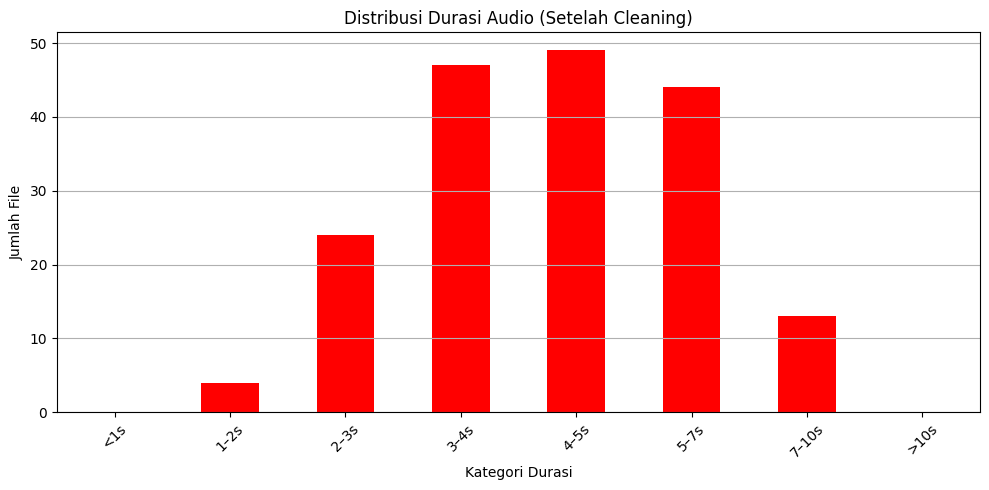

In [ ]:
# Ubah jadi DataFrame
df_cleaned = pd.DataFrame(cleaned_data)

# Binning durasi
bins = [0, 1, 2, 3, 4, 5, 7, 10, np.inf]
labels = ['<1s', '1–2s', '2–3s', '3–4s', '4–5s', '5–7s', '7–10s', '>10s']
df_cleaned['duration_category'] = pd.cut(df_cleaned['duration'], bins=bins, labels=labels)

# Plot
plt.figure(figsize=(10, 5))
df_cleaned['duration_category'].value_counts(sort=False).plot(kind='bar', color='red')
plt.title('Distribusi Durasi Audio (Setelah Cleaning)')
plt.xlabel('Kategori Durasi')
plt.ylabel('Jumlah File')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##  Visualisasi Age, Gender, dan Accent

### menggunakan barchar

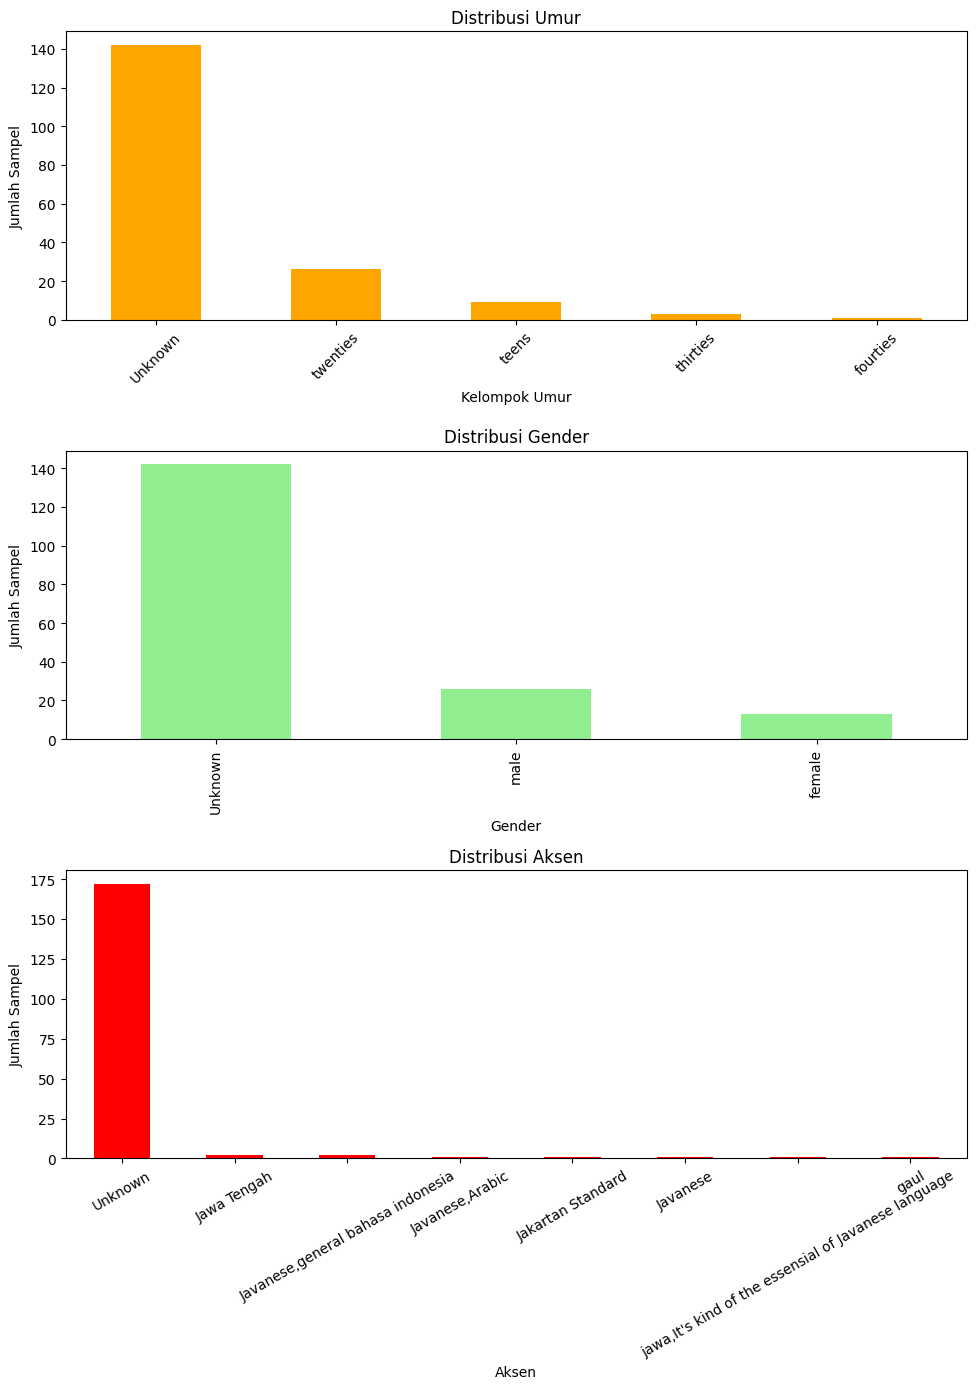

In [ ]:
# Salin DataFrame dan isi nilai kosong dengan label "Unknown"
df_viz = df_cleaned.copy()
df_viz['age'] = df_viz['age'].replace('', np.nan).fillna('Unknown')
df_viz['gender'] = df_viz['gender'].replace('', np.nan).fillna('Unknown')
df_viz['accent'] = df_viz['accent'].replace('', np.nan).fillna('Unknown')

fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Age
df_viz['age'].value_counts().plot(kind='bar', ax=axes[0], color='orange')
axes[0].set_title('Distribusi Umur')
axes[0].set_xlabel('Kelompok Umur')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].tick_params(axis='x', rotation=45)

# Gender
df_viz['gender'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Distribusi Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Jumlah Sampel')

# Accent
df_viz['accent'].value_counts().plot(kind='bar', ax=axes[2], color='red')
axes[2].set_title('Distribusi Aksen')
axes[2].set_xlabel('Aksen')
axes[2].set_ylabel('Jumlah Sampel')
axes[2].tick_params(axis='x',  rotation=30, labelsize=10)

plt.tight_layout()
plt.show()


### menggunakan piechar

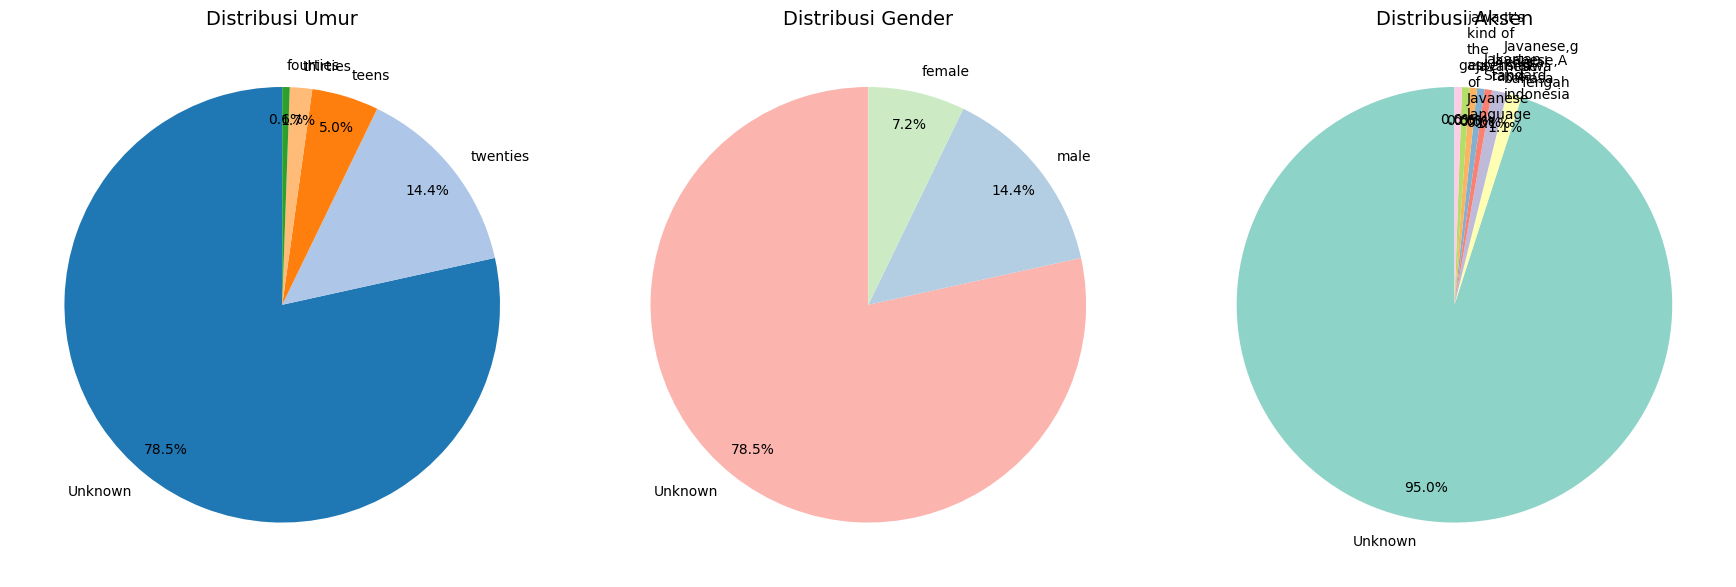

In [ ]:
from textwrap import wrap
# Pastikan df_cleaned sudah ada
df_viz = df_cleaned.copy()
df_viz['age'] = df_viz['age'].replace('', np.nan).fillna('Unknown')
df_viz['gender'] = df_viz['gender'].replace('', np.nan).fillna('Unknown')
df_viz['accent'] = df_viz['accent'].replace('', np.nan).fillna('Unknown')

# Bungkus label panjang aksen
# Mengurangi lebar wrap agar label lebih rapi jika ada banyak kategori
accent_counts = df_viz['accent'].value_counts()
accent_labels_wrapped = ['\n'.join(wrap(label, 10)) for label in accent_counts.index] # Mengurangi lebar wrap menjadi 10

# Buat plot pie chart
# Mengubah layout menjadi 1 baris, 3 kolom agar lebih mudah diatur
fig, axes = plt.subplots(1, 3, figsize=(18, 8)) # Mengubah figsize untuk layout horizontal

# Distribusi Umur
age_counts = df_viz['age'].value_counts()
# Menyesuaikan labeldistance dan menambahkan pctdistance untuk autopct
wedges, texts, autotexts = axes[0].pie(age_counts, labels=age_counts.index, autopct='%1.1f%%',
                                       startangle=90, colors=plt.cm.tab20.colors,
                                       pctdistance=0.85, labeldistance=1.1) # Sesuaikan labeldistance dan pctdistance
axes[0].set_title('Distribusi Umur', fontsize=14) # Menambahkan ukuran font untuk judul
# Mengatur warna teks persentase agar lebih terlihat
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

# Distribusi Gender
gender_counts = df_viz['gender'].value_counts()
wedges, texts, autotexts = axes[1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
                                       startangle=90, colors=plt.cm.Pastel1.colors,
                                       pctdistance=0.85, labeldistance=1.1) # Sesuaikan labeldistance dan pctdistance
axes[1].set_title('Distribusi Gender', fontsize=14)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

# Distribusi Aksen
wedges, texts, autotexts = axes[2].pie(accent_counts, labels=accent_labels_wrapped, autopct='%1.1f%%',
                                       startangle=90, colors=plt.cm.Set3.colors,
                                       pctdistance=0.85, labeldistance=1.1) # Sesuaikan labeldistance dan pctdistance
axes[2].set_title('Distribusi Aksen', fontsize=14)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

# Mengatur tata letak agar tidak ada tumpang tindih
plt.tight_layout(pad=3.0) # Menambahkan padding antar subplot
plt.show()


In [ ]:
import json
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path penyimpanan di Google Drive
drive_path = "/content/drive/MyDrive/skripsi ryan/cleaned_data.json"
output_path = "/content/cleaned_data.json"


with open(output_path, "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=2)

print(f"✅ Data berhasil disimpan ke {output_path}")

shutil.copy(output_path, drive_path)

# Salin file dari local ke Google Drive
print(f"✅ File berhasil disalin ke {drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data berhasil disimpan ke /content/cleaned_data.json
✅ File berhasil disalin ke /content/drive/MyDrive/skripsi ryan/cleaned_data.json


# insialisasi

In [ ]:
# Inisialisasi dari jumlah data yang sudah dibersihkan
N = len(cleaned_data)
results = {
    "whisper": {"wer": 0, "time": 0, "duration": 0},
    "wav2vec2": {"wer": 0, "time": 0, "duration": 0}
}

print(f"Evaluating on {N} cleaned samples...\n")


Evaluating on 181 cleaned samples...



# Evaluasi

In [ ]:
# Fungsi bantu klasifikasi (tempatkan di awal)
def classify_length(duration):
    if duration < 3:
        return 'short'
    elif duration < 7:
        return 'medium'
    else:
        return 'long'

def classify_quality(wer):
    if wer < 0.2:
        return 'high'
    elif wer < 0.5:
        return 'medium'
    else:
        return 'low'

eval_results = []

print(f"Evaluating on {N} cleaned samples...\n")

for i in range(N):
    sample_data = cleaned_data[i]
    audio_path = sample_data["path"]
    ref_text = sample_data["text"]
    duration = sample_data["duration"]

    print(f"\n=== Sample {i+1} ===")
    print(f"Reference: {ref_text}")

    # Load audio data using librosa
    try:
        orig_array, orig_sr = librosa.load(audio_path, sr=16000) # Load at 16kHz
    except Exception as e:
        print(f"Skipping sample {i+1}: Could not load audio file from {audio_path} - {e}")
        continue


    # === Whisper ===
    try:
        # Prepare audio for Whisper (needs a dictionary with 'array' and 'sampling_rate')
        whisper_audio_input = {"array": orig_array, "sampling_rate": orig_sr}
        t0 = time.time()
        # Specify language and task for Whisper
        whisper_out = whisper_pipe(whisper_audio_input, generate_kwargs={"language": "id", "task": "transcribe"})
        t1 = time.time()
        whisper_text = whisper_out["text"]
        # whisper_wer = wer(ref_text.lower(), whisper_text.lower())
        whisper_wer = wer(ref_text, whisper_text)
        whisper_time = t1 - t0
        start_cpu = psutil.cpu_percent(interval=None)
        start_mem = psutil.virtual_memory().used / (1024 ** 2)
        whisper_cpu = psutil.cpu_percent(interval=None) - start_cpu
        whisper_mem = (psutil.virtual_memory().used / (1024 ** 2)) - start_mem


        results['whisper']['wer'] += whisper_wer
        results['whisper']['time'] += whisper_time
        results['whisper']['duration'] += duration

        print(f"[Whisper]")
        print(f"- Output: {whisper_text}")
        print(f"- WER: {whisper_wer:.3f} | Time: {whisper_time:.2f}s | CPU: {whisper_cpu:.2f} | memory: {whisper_mem:.2f}")

    except Exception as e:
        print(f"[Whisper] Error on sample {i+1}: {e}")
        whisper_text = "Error during transcription"
        whisper_wer = 1.0 # Assign maximum WER on error
        whisper_time = 0.0
        # continue # Don't skip the whole sample if one model fails

    # === Wav2Vec2 ===
    try:
        # Wav2Vec2 pipe directly accepts numpy array
        t0 = time.time()
        w2v2_out = w2v2_pipe(orig_array) # Use the 16kHz array
        t1 = time.time()
        w2v2_text = w2v2_out["text"]
        # w2v2_wer = wer(ref_text.lower(), w2v2_text.lower())
        w2v2_wer = wer(ref_text, w2v2_text)
        w2v2_time = t1 - t0
        start_cpu = psutil.cpu_percent(interval=None)
        start_mem = psutil.virtual_memory().used / (1024 ** 2)
        w2v2_cpu = psutil.cpu_percent(interval=None) - start_cpu
        w2v2_mem = (psutil.virtual_memory().used / (1024 ** 2)) - start_mem

        results['wav2vec2']['wer'] += w2v2_wer
        results['wav2vec2']['time'] += w2v2_time
        results['wav2vec2']['duration'] += duration

        print(f"[Wav2Vec2]")
        print(f"- Output: {w2v2_text}")
        print(f"- WER: {w2v2_wer:.3f} | Time: {w2v2_time:.2f}s | CPU: {w2v2_cpu:.2f} | memory: {w2v2_mem:.2f}")

    except Exception as e:
        print(f"[Wav2Vec2] Error on sample {i+1}: {e}")
        w2v2_text = "Error during transcription"
        w2v2_wer = 1.0 # Assign maximum WER on error
        w2v2_time = 0.0
        # continue # Don't skip the whole sample if one model fails

       # === Klasifikasi audio ===
    audio_length = classify_length(duration)
    audio_quality = classify_quality(whisper_wer)


    # Tambahkan ke hasil
    eval_results.append({
        "reference_text": ref_text,
        "duration": duration,
        "audio_length": audio_length,
        "audio_quality": audio_quality,
        "whisper_output": whisper_text,
        "whisper_wer": whisper_wer,
        "whisper_time": whisper_time,
        "whisper_cpu": whisper_cpu,
        "whisper_mem": whisper_mem,
        "wav2vec2_output": w2v2_text,
        "wav2vec2_wer": w2v2_wer,
        "wav2vec2_time": w2v2_time,
        "wav2vec2_cpu": w2v2_cpu,
        "wav2vec2_mem": w2v2_mem
    })



Evaluating on 181 cleaned samples...


=== Sample 1 ===
Reference: maha suci allah


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Makasih, Allah.
- WER: 1.000 | Time: 0.45s | CPU: -15.90 | memory: 0.00
[Wav2Vec2]
- Output: mahan siden au
- WER: 1.000 | Time: 0.08s | CPU: -50.00 | memory: 0.00

=== Sample 2 ===
Reference: inilah dunia kecil


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Inilah dunia kecil.
- WER: 0.667 | Time: 0.35s | CPU: -54.90 | memory: 0.00
[Wav2Vec2]
- Output: inilah dunia keci
- WER: 0.333 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 3 ===
Reference: nol
[Whisper]
- Output:  nah
- WER: 1.000 | Time: 0.24s | CPU: -59.20 | memory: 0.00
[Wav2Vec2]
- Output: nol
- WER: 0.000 | Time: 0.03s | CPU: -57.10 | memory: 0.00

=== Sample 4 ===
Reference: aku tidak tahu artinya kebencian
[Whisper]
- Output:  Aku tidak tahu artinya kebencian.
- WER: 0.400 | Time: 0.39s | CPU: 45.60 | memory: 0.00
[Wav2Vec2]
- Output: aku tindak tahu artinga kemensian
- WER: 0.600 | Time: 0.06s | CPU: -45.50 | memory: 0.00

=== Sample 5 ===
Reference: tugas saya belom kelar
[Whisper]
- Output:  Tuga saya belom kalar.
- WER: 0.500 | Time: 0.37s | CPU: -53.40 | memory: 0.00
[Wav2Vec2]
- Output: duka saya belum gelar
- WER: 0.750 | Time: 0.03s | CPU: -42.90 | memory: 0.00

=== Sample 6 ===
Reference: itu tadi menarik ya
[Whisper]
- Output:  itu tadi 

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Salam Perki!
- WER: 1.000 | Time: 0.30s | CPU: -52.50 | memory: 0.00
[Wav2Vec2]
- Output: songan pergi
- WER: 0.500 | Time: 0.04s | CPU: -57.10 | memory: 0.00

=== Sample 10 ===
Reference: semua kamus mengandung kesalahan
[Whisper]
- Output:  maka kamu semua mengandung kesalahan.
- WER: 1.000 | Time: 0.47s | CPU: -61.70 | memory: 0.00
[Wav2Vec2]
- Output: mua kamus menganbu kesalaan
- WER: 0.750 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 11 ===
Reference: tom pasti telah bekerja sangat keras


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tom pasti telah berkerja sangat keras.
- WER: 0.500 | Time: 0.42s | CPU: -52.90 | memory: 0.00
[Wav2Vec2]
- Output: tom pasti telah bekerja sangat keras
- WER: 0.000 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 12 ===
Reference: makanan yang saya sukai adalah kare
[Whisper]
- Output:  Makanan yang saya sukai adalah karek.
- WER: 0.333 | Time: 0.47s | CPU: -58.90 | memory: 0.00
[Wav2Vec2]
- Output: makanan yang saya sekai adalah khare
- WER: 0.333 | Time: 0.12s | CPU: -78.30 | memory: 0.00

=== Sample 13 ===
Reference: keretanya di sini


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  retanya disini
- WER: 1.000 | Time: 0.30s | CPU: -51.70 | memory: 0.00
[Wav2Vec2]
- Output: keretanya di sini
- WER: 0.000 | Time: 0.03s | CPU: -50.00 | memory: 0.00

=== Sample 14 ===
Reference: makan malam kemarin adalah masakan daging
[Whisper]
- Output:  Makan malam kemarin adalah masakan daging.
- WER: 0.333 | Time: 0.46s | CPU: -56.80 | memory: 0.00
[Wav2Vec2]
- Output: makan malam kemarin adalah masakan daging
- WER: 0.000 | Time: 0.08s | CPU: -61.10 | memory: 0.00

=== Sample 15 ===
Reference: aku ingin kamu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku ingin kamu.
- WER: 0.667 | Time: 0.33s | CPU: -67.20 | memory: 0.00
[Wav2Vec2]
- Output: aku ingin kamu
- WER: 0.000 | Time: 0.04s | CPU: -44.40 | memory: 0.00

=== Sample 16 ===
Reference: semestinya tidak ada koma pada kalimat ini
[Whisper]
- Output:  semestinya tidak ada korma pada kanima ini.
- WER: 0.429 | Time: 0.46s | CPU: -52.70 | memory: 0.00
[Wav2Vec2]
- Output: semestinya tidak ada koma pada kalimnat ini
- WER: 0.143 | Time: 0.08s | CPU: -62.50 | memory: 0.00

=== Sample 17 ===
Reference: parkirkan saja mobilmu di belakang taman rumahku
[Whisper]
- Output:  Parkirkan saja mobilmu di belakang taman rumahku.
- WER: 0.286 | Time: 0.57s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: pargirkan saja mobilmuh di belakang taman rumahku
- WER: 0.286 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 18 ===
Reference: permisi bisa beritahu jalan ke halte bis
[Whisper]
- Output:  Permisi bisa beritahu jalan ke Hatobis?
- WER: 0.429 | Time: 0.59s | CPU:

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH BUNUH
- WER: 111.000 | Time: 11.52s | CPU: -65.70 | memory: 0.00
[Wav2Vec2]
- Output: a
- WER: 1.000 | Time: 0.08s | CPU: -100.00 | memory: 0.00

=== Sample 20 ===
Reference: lalu lintas jakarta selatan di hari senin pagi biasanya macet


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Lalu lintas jakar pasirotan dihariskan impact BSNnya macet.
- WER: 0.900 | Time: 0.94s | CPU: 0.50 | memory: 0.25
[Wav2Vec2]
- Output: lalu linter jekat peseotan lihari senin pak diasanya makset
- WER: 0.800 | Time: 0.10s | CPU: -100.00 | memory: 0.00

=== Sample 21 ===
Reference: jika menggunakan transportasi publik mohon untuk mendahulukan penumpang prioritas untuk mendapatkan tempat duduk


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Jika menggunakan transporuterasi publik, Mohon untuk mendahulukan penumpang prioritas untuk mendapatkan tempat duduk.
- WER: 0.385 | Time: 1.12s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: jika menggunakan tran suarterasi pablik mohon untuk mendahulukan enumpang priolitas untuk mendapatkan tempat duduk
- WER: 0.385 | Time: 0.14s | CPU: -100.00 | memory: 0.00

=== Sample 22 ===
Reference: saya memasukkan tiga sendok gula dengan sendok


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Sayang, masukkan 3 senbuk gula dengan senbuk.
- WER: 0.714 | Time: 0.77s | CPU: -98.10 | memory: 0.00
[Wav2Vec2]
- Output: saya memasukkan tiga saang bagula dengan senk
- WER: 0.429 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 23 ===
Reference: kami akan mengadakan sebuah pesta pada malam sabtu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kami akan menghadapkan sebuah kesta pada malam 1.
- WER: 0.500 | Time: 0.62s | CPU: -86.40 | memory: 0.00
[Wav2Vec2]
- Output: kami akan mengadakan sebuah pesta pada malam sabtu
- WER: 0.000 | Time: 0.09s | CPU: -68.40 | memory: 0.00

=== Sample 24 ===
Reference: kesimpulan ini sulit untuk dipungkiri


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kasih pulaan ini sulit untuk tuk tuk tiri.
- WER: 1.000 | Time: 0.54s | CPU: -59.10 | memory: 0.00
[Wav2Vec2]
- Output: kesembulan ini sulit untuk dupung kiri
- WER: 0.600 | Time: 0.06s | CPU: -54.50 | memory: 0.00

=== Sample 25 ===
Reference: cek dana masuk
[Whisper]
- Output:  terima kasih
- WER: 1.000 | Time: 0.38s | CPU: -55.70 | memory: 0.00
[Wav2Vec2]
- Output: sidana masuk
- WER: 0.667 | Time: 0.05s | CPU: -60.00 | memory: 0.00

=== Sample 26 ===
Reference: tom pindah keluar tiga minggu yang lalu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tom pindah keluar 3 minggu yang lalu.
- WER: 0.429 | Time: 0.55s | CPU: -56.90 | memory: 0.00
[Wav2Vec2]
- Output: tom pindah keluar tiga minggu yang lalu
- WER: 0.000 | Time: 0.05s | CPU: -60.00 | memory: 0.00

=== Sample 27 ===
Reference: tolong buka jendela di sana


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tolong buka cendela di sana.
- WER: 0.600 | Time: 0.42s | CPU: -54.20 | memory: 0.00
[Wav2Vec2]
- Output: tolong buka jendela di sana
- WER: 0.000 | Time: 0.04s | CPU: 50.00 | memory: 0.00

=== Sample 28 ===
Reference: pada ketinggian itu cuaca dapat berubah secara cepat tanpa peringatan
[Whisper]
- Output:  Pada ketujian itu cuaca dapat berubah secara sepatu tanpa peringatan.
- WER: 0.400 | Time: 0.79s | CPU: -60.10 | memory: 0.00
[Wav2Vec2]
- Output: ada tepigia itu cuaca dapat berubah secara cepat tampa peringatan
- WER: 0.300 | Time: 0.10s | CPU: -95.20 | memory: 0.00

=== Sample 29 ===
Reference: dia lebih kuat darimu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Dia lebih kuat darimu.
- WER: 0.500 | Time: 0.53s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: dia lebih kuat darimu
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 30 ===
Reference: tom melihat kepada mary


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tom melihat kepada Mary.
- WER: 0.500 | Time: 0.47s | CPU: -100.00 | memory: 0.25
[Wav2Vec2]
- Output: tom melihat kepandelan mary
- WER: 0.250 | Time: 0.07s | CPU: -53.30 | memory: 0.00

=== Sample 31 ===
Reference: saya membeli kalender tahun depan di toserba
[Whisper]
- Output:  Saya membeli kalender tahun depan di top serba.
- WER: 0.429 | Time: 0.52s | CPU: -56.30 | memory: 0.00
[Wav2Vec2]
- Output: saya membel di kalender tahun depan di toserba
- WER: 0.286 | Time: 0.11s | CPU: -50.00 | memory: 0.00

=== Sample 32 ===
Reference: coba lakukan dengan cara berbeda
[Whisper]
- Output:  coba lakukan dengan cara berbeda
- WER: 0.000 | Time: 0.48s | CPU: -58.30 | memory: 0.00
[Wav2Vec2]
- Output: cobelahukan dengan cara berbeda
- WER: 0.400 | Time: 0.08s | CPU: -60.00 | memory: 0.00

=== Sample 33 ===
Reference: kuingin pergi sendiri berlibur ke pulau tak berpenghuni itu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kau ingin pergi sendiri berlibur ke pulau tak berpengkuni itu.
- WER: 0.444 | Time: 0.66s | CPU: -52.70 | memory: 0.00
[Wav2Vec2]
- Output: kuingin pergi sendiri berlibur ke pulau tak berpongkuni itu
- WER: 0.111 | Time: 0.06s | CPU: -66.70 | memory: 0.00

=== Sample 34 ===
Reference: saya sudah mengenalnya sejak kecil


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  saya sudah mengenalnya sejak kecil
- WER: 0.000 | Time: 0.45s | CPU: -58.90 | memory: 0.00
[Wav2Vec2]
- Output: saya sudah mengenalnya sejak kecil
- WER: 0.000 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 35 ===
Reference: kenapa kamu tidak datang malam minggu kemarin
[Whisper]
- Output:  Kenapa kamu tidak datang malam minggu kemarin?
- WER: 0.286 | Time: 0.57s | CPU: -56.00 | memory: 0.00
[Wav2Vec2]
- Output: kenapa kamu tidak datang malam minggu kemarin
- WER: 0.000 | Time: 0.05s | CPU: -54.50 | memory: 0.00

=== Sample 36 ===
Reference: dunia akan melihat kita


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  dunia akan melihat kita
- WER: 0.000 | Time: 0.37s | CPU: -59.50 | memory: 0.00
[Wav2Vec2]
- Output: dunia akan melihat kita
- WER: 0.000 | Time: 0.05s | CPU: -60.00 | memory: 0.00

=== Sample 37 ===
Reference: saya berbisnis di sini


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Cyber business disini.
- WER: 1.000 | Time: 0.31s | CPU: -51.60 | memory: 0.00
[Wav2Vec2]
- Output: saya berbisnis di sini
- WER: 0.000 | Time: 0.03s | CPU: -62.50 | memory: 0.00

=== Sample 38 ===
Reference: kamu tahu tidak
[Whisper]
- Output:  Kamu tahu tidak?
- WER: 0.667 | Time: 0.37s | CPU: -58.10 | memory: 0.00
[Wav2Vec2]
- Output: kamu tahu tidak
- WER: 0.000 | Time: 0.06s | CPU: -90.90 | memory: 0.00

=== Sample 39 ===
Reference: saya sedang makan nasi padang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya sedang makan hasil padang.
- WER: 0.600 | Time: 0.39s | CPU: -52.50 | memory: 0.00
[Wav2Vec2]
- Output: saya sedang makan hasi padang
- WER: 0.200 | Time: 0.08s | CPU: -56.30 | memory: 0.00

=== Sample 40 ===
Reference: tom terlihat tidak tertarik
[Whisper]
- Output:  Tom terlihat tidak tarik.
- WER: 0.500 | Time: 0.43s | CPU: -57.00 | memory: 0.00
[Wav2Vec2]
- Output: tom selihat tidak tari
- WER: 0.500 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 41 ===
Reference: sami bisa mengubah dirinya sendiri


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Sami bisa membuat pilihnya sendiri.
- WER: 0.800 | Time: 0.50s | CPU: -77.20 | memory: 0.00
[Wav2Vec2]
- Output: sami bisa mengubah didenmil sendiri
- WER: 0.200 | Time: 0.05s | CPU: -90.90 | memory: 0.00

=== Sample 42 ===
Reference: namaku adalah ludoviko
[Whisper]
- Output:  Namaku adalah Ludovico.
- WER: 0.667 | Time: 0.48s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: nama gulu adalah hidoviko
- WER: 1.000 | Time: 0.06s | CPU: 0.00 | memory: 0.00

=== Sample 43 ===
Reference: saya tidak takut hantu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya tidak takut hantu.
- WER: 0.500 | Time: 0.39s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: saya tidak takut hantu
- WER: 0.000 | Time: 0.04s | CPU: -100.00 | memory: 0.00

=== Sample 44 ===
Reference: makanlah
[Whisper]
- Output:  Makanlah.
- WER: 1.000 | Time: 0.31s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: makanlah
- WER: 0.000 | Time: 0.03s | CPU: -100.00 | memory: 0.00

=== Sample 45 ===
Reference: satu
[Whisper]
- Output:  Satu
- WER: 1.000 | Time: 0.30s | CPU: -98.40 | memory: 0.00
[Wav2Vec2]
- Output: satu
- WER: 0.000 | Time: 0.04s | CPU: -100.00 | memory: 0.00

=== Sample 46 ===
Reference: tiga
[Whisper]
- Output:  dike
- WER: 1.000 | Time: 0.25s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: tiga
- WER: 0.000 | Time: 0.04s | CPU: 0.00 | memory: 0.00

=== Sample 47 ===
Reference: dimanakah rasa malumu hingga kamu berani berbuat sepert itu
[Whisper]
- Output:  Dimanakah rasa malumu, tinggal kamu berani berbuat seperti itu?
- WER: 0.5

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya pergi ke rumah teman setelah pelajaran selesai.
- WER: 0.250 | Time: 0.66s | CPU: -70.70 | memory: 0.00
[Wav2Vec2]
- Output: saya pergi ke rumah teman setelah pelajaran selesai
- WER: 0.000 | Time: 0.10s | CPU: -70.00 | memory: 0.00

=== Sample 49 ===
Reference: nama keluarga saya adalah wang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Nama keluarga saya adalah Wam.
- WER: 0.400 | Time: 0.39s | CPU: -55.80 | memory: 0.00
[Wav2Vec2]
- Output: nama keluarga saya adalah wang
- WER: 0.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 50 ===
Reference: setelah minum saya mencuci gelas sampai bersih
[Whisper]
- Output:  Setelah minum, saya mencuci gelas sampai bersih.
- WER: 0.429 | Time: 0.54s | CPU: -53.20 | memory: 0.00
[Wav2Vec2]
- Output: setelah minum saya mencuci gelas sampai bersi
- WER: 0.143 | Time: 0.08s | CPU: -56.30 | memory: 0.00

=== Sample 51 ===
Reference: di kelas ada komputer baru
[Whisper]
- Output:  Di kelas ada komputer baru.
- WER: 0.400 | Time: 0.45s | CPU: -59.30 | memory: 0.00
[Wav2Vec2]
- Output: di kelas anda komputerbaru
- WER: 0.600 | Time: 0.06s | CPU: -54.50 | memory: 0.00

=== Sample 52 ===
Reference: ini di luar pertanyaan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Ini di luar pertanyaan.
- WER: 0.500 | Time: 0.40s | CPU: -62.50 | memory: 0.00
[Wav2Vec2]
- Output: ini diluar pertanyaan
- WER: 0.500 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 53 ===
Reference: kalau tidak ketemu coba carilah di sekitar galaxy mall


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kalau tidak ketemu, coba carilah di sekitar Galaxy Mall.
- WER: 0.444 | Time: 0.55s | CPU: -54.50 | memory: 0.00
[Wav2Vec2]
- Output: kalau tidak ketemu cobacarilah di sekitar dalang simul
- WER: 0.444 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 54 ===
Reference: dokter dengan pasien nya
[Whisper]
- Output:  Dokter dengan pasiennya.
- WER: 0.750 | Time: 0.36s | CPU: -52.80 | memory: 0.00
[Wav2Vec2]
- Output: dokter dengan pasiennya
- WER: 0.500 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 55 ===
Reference: cara terbaik agar mimpimu menjadi kenyataan adalah bangun
[Whisper]
- Output:  Cara terbaik agar mimpimu menjadi kenyataan adalah bangun.
- WER: 0.250 | Time: 0.68s | CPU: -58.10 | memory: 0.00
[Wav2Vec2]
- Output: cara terbaik akhir mimpimu menjadi kenyatan adalah banggun
- WER: 0.375 | Time: 0.08s | CPU: -53.30 | memory: 0.00

=== Sample 56 ===
Reference: tom sangat menyukai bermain basket


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tom sangat menyukai bermain basket.
- WER: 0.400 | Time: 0.48s | CPU: -56.30 | memory: 0.00
[Wav2Vec2]
- Output: tom sangat menyukai bermain basket
- WER: 0.000 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 57 ===
Reference: saya hubungi lagi nanti
[Whisper]
- Output:  Saya hupungi lagi nanti.
- WER: 0.750 | Time: 0.40s | CPU: -58.50 | memory: 0.00
[Wav2Vec2]
- Output: saya hukungi laki nanti
- WER: 0.500 | Time: 0.05s | CPU: -10.00 | memory: 0.00

=== Sample 58 ===
Reference: jangan lupa ya datang ke acara ulangtahunku


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Jangan lupa ya datang ke acara orang tahun itu.
- WER: 0.571 | Time: 0.53s | CPU: -58.30 | memory: 0.00
[Wav2Vec2]
- Output: jangan lupak ya datang kaacara ulang tahun
- WER: 0.571 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 59 ===
Reference: dua
[Whisper]
- Output:  MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENUKAN MENU

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Sorry.
- WER: 1.000 | Time: 0.27s | CPU: -59.30 | memory: 0.00
[Wav2Vec2]
- Output: sama mayuran
- WER: 2.000 | Time: 0.04s | CPU: -62.50 | memory: 0.00

=== Sample 61 ===
Reference: besok saya akan pergi menonton film bersama teman
[Whisper]
- Output:  Besok saya akan pergi ngomong film bersama teman.
- WER: 0.375 | Time: 0.55s | CPU: -56.40 | memory: 0.00
[Wav2Vec2]
- Output: besok saya akan pergi menhon film bersama temat
- WER: 0.250 | Time: 0.06s | CPU: -46.20 | memory: 0.00

=== Sample 62 ===
Reference: pak tanaka minum cocacola


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Pak Tanaka, nunggu kakak kuala.
- WER: 1.250 | Time: 0.50s | CPU: -59.00 | memory: 0.00
[Wav2Vec2]
- Output: pak tanaka inu keparakola
- WER: 0.500 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 63 ===
Reference: awas lantai licin


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Awas, lantai licin.
- WER: 0.667 | Time: 0.40s | CPU: -54.30 | memory: 0.00
[Wav2Vec2]
- Output: alas lantai licin
- WER: 0.333 | Time: 0.05s | CPU: -60.00 | memory: 0.00

=== Sample 64 ===
Reference: ayah saya bekerja di sebuah pabrik
[Whisper]
- Output:  Ayah saya bekerja di sebuah abri.
- WER: 0.333 | Time: 0.47s | CPU: -65.30 | memory: 0.00
[Wav2Vec2]
- Output: ayah saya bekerja di sebuah abrik
- WER: 0.167 | Time: 0.06s | CPU: -46.20 | memory: 0.00

=== Sample 65 ===
Reference: aku sakit


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku sakit.
- WER: 1.000 | Time: 0.34s | CPU: -73.10 | memory: 0.00
[Wav2Vec2]
- Output: aku sakit
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 66 ===
Reference: semangat untuk hari ini
[Whisper]
- Output:  Semangat untuk hari ini.
- WER: 0.500 | Time: 0.55s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: semangat untuk hari ini
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 67 ===
Reference: pernah ke amerika


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Pernah ke Amerika.
- WER: 0.667 | Time: 0.36s | CPU: -87.80 | memory: 0.00
[Wav2Vec2]
- Output: pernah ke amerika
- WER: 0.000 | Time: 0.06s | CPU: -58.30 | memory: 0.00

=== Sample 68 ===
Reference: apakah kamu pernah mendaki gunung fuji
[Whisper]
- Output:  Apakah kamu pernah mendaki gunung kuji?
- WER: 0.333 | Time: 0.46s | CPU: -56.00 | memory: 0.00
[Wav2Vec2]
- Output: apakah kamu pernah mengdaki gunung kuji
- WER: 0.333 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 69 ===
Reference: saya setiap pagi pergi jalanjalan
[Whisper]
- Output:  Saya setiap pagi pergi jalan-jalan.
- WER: 0.400 | Time: 0.57s | CPU: -58.80 | memory: 0.00
[Wav2Vec2]
- Output: saya setiap pagi pergi jalanjalan
- WER: 0.000 | Time: 0.07s | CPU: -62.50 | memory: 0.00

=== Sample 70 ===
Reference: air mengalir adalah air yang bersih


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Air mengalir adalah air yang bersih.
- WER: 0.333 | Time: 0.43s | CPU: -57.60 | memory: 0.00
[Wav2Vec2]
- Output: air memngalir adalah air yang bersih
- WER: 0.167 | Time: 0.06s | CPU: 54.50 | memory: 0.00

=== Sample 71 ===
Reference: minggu depan kakak perempuan saya menikah
[Whisper]
- Output:  Minggu depan kakak perbuatan saya menikah.
- WER: 0.500 | Time: 0.59s | CPU: -78.20 | memory: 0.00
[Wav2Vec2]
- Output: minggu depan kakak perepuan saya menikah
- WER: 0.167 | Time: 0.06s | CPU: -91.70 | memory: 0.00

=== Sample 72 ===
Reference: aku pernah ingin menjadi seorang astronom fisika
[Whisper]
- Output:  Aku pernah ingin menjadi seorang astronom fisika.
- WER: 0.286 | Time: 0.56s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: aku pernah ingin menjadi seorang astronom visika
- WER: 0.143 | Time: 0.11s | CPU: -100.00 | memory: 0.00

=== Sample 73 ===
Reference: saya sedang mencari dompet hitam seperti ini


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  saya sedang mencari dompet hitam seperti ini
- WER: 0.000 | Time: 0.54s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: saya sedang mencari dompet hitam seperti ini
- WER: 0.000 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 74 ===
Reference: apakah anda pernah makan serangga
[Whisper]
- Output:  Apakah Anda pernah makan serangga?
- WER: 0.600 | Time: 0.44s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: apakah anda pernah makan serangga
- WER: 0.000 | Time: 0.07s | CPU: -100.00 | memory: 0.00

=== Sample 75 ===
Reference: rencananya kita akan pergi ke estonia bulan depan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Rencananya kita akan pergi ke Estonia bulan depan.
- WER: 0.375 | Time: 0.68s | CPU: -98.50 | memory: 0.00
[Wav2Vec2]
- Output: rencananya kita akan pergi ke estonia bulan depan
- WER: 0.000 | Time: 0.10s | CPU: -100.00 | memory: 0.00

=== Sample 76 ===
Reference: pak tanaka tinggal di rumah besar


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Pak Tanaka tinggal di rumah besar.
- WER: 0.500 | Time: 0.41s | CPU: -78.30 | memory: 0.00
[Wav2Vec2]
- Output: pak tanaka tinggal di rumah besar
- WER: 0.000 | Time: 0.06s | CPU: -58.30 | memory: 0.00

=== Sample 77 ===
Reference: itu kelinci yang jahat
[Whisper]
- Output:  Itu kelinci yang jahat.
- WER: 0.500 | Time: 0.47s | CPU: -64.90 | memory: 0.00
[Wav2Vec2]
- Output: itu kelinci yang jahat
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 78 ===
Reference: apakah anda percaya pada tuhan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Apakah Anda percaya-percaya?
- WER: 1.000 | Time: 0.53s | CPU: -56.60 | memory: 0.00
[Wav2Vec2]
- Output: apakahannya kusui pada dia
- WER: 0.800 | Time: 0.05s | CPU: -55.60 | memory: 0.00

=== Sample 79 ===
Reference: semuanya sedang menunggu guru di kelas


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Semuanya itu menurut kerasnya.
- WER: 1.000 | Time: 0.48s | CPU: -55.70 | memory: 0.00
[Wav2Vec2]
- Output: semua mi jadang menus guru di keras
- WER: 0.833 | Time: 0.06s | CPU: -45.50 | memory: 0.00

=== Sample 80 ===
Reference: anakanak kecil suka dengan buku tentang dinosaurus dan monster
[Whisper]
- Output:  Kami ada kecil sepatutnya untuk berbicara dengan yang tidak selamat dan yang tidak selamat.
- WER: 1.222 | Time: 0.79s | CPU: -57.60 | memory: 0.00
[Wav2Vec2]
- Output: ama anak ecir suka yang pukul perbaah ke maustauih tan monsta
- WER: 1.111 | Time: 0.09s | CPU: -55.00 | memory: 0.00

=== Sample 81 ===
Reference: perusahaan yang berkembang selalu diikuti dengan perkembangan teknologi didalamnya


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Perusahaan yang berkembang selalu dibutuhi dengan perkembang antenneluki di dalamnya.
- WER: 0.667 | Time: 0.91s | CPU: -57.40 | memory: 0.00
[Wav2Vec2]
- Output: perusahan yang berkempiang selalu cibutih dengan pul tempanga tehlaluki di dalamnya
- WER: 0.889 | Time: 0.12s | CPU: -54.20 | memory: 0.00

=== Sample 82 ===
Reference: zlatan sedang menderita cidera siku


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Selatam sedang meneritaji direpsiku.
- WER: 0.800 | Time: 0.52s | CPU: -58.50 | memory: 0.00
[Wav2Vec2]
- Output: selatang sedang menderitaci de raksiku
- WER: 0.800 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 83 ===
Reference: dia buruburu pulang dari inggris


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tia Purupuru Pulantari Gris
- WER: 1.000 | Time: 0.44s | CPU: -60.90 | memory: 0.00
[Wav2Vec2]
- Output: dia buruh buruh pulang dari inggris
- WER: 0.400 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 84 ===
Reference: mau kopi atau teh
[Whisper]
- Output:  Auk koplat aukteh.
- WER: 1.000 | Time: 0.37s | CPU: -57.10 | memory: 0.00
[Wav2Vec2]
- Output: mauko ketatau peh
- WER: 1.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 85 ===
Reference: kurakura adalah reptil


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kura-kura dari Reptio.
- WER: 1.000 | Time: 0.44s | CPU: -55.70 | memory: 0.00
[Wav2Vec2]
- Output: gura kura adalah reptio
- WER: 1.000 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 86 ===
Reference: tom memberi mary sekotak coklat
[Whisper]
- Output:  Tom memberi Mary sebuah kota coklat.
- WER: 1.000 | Time: 0.47s | CPU: -52.10 | memory: 0.00
[Wav2Vec2]
- Output: tom memberi mary sekotak coklat
- WER: 0.000 | Time: 0.06s | CPU: -58.30 | memory: 0.00

=== Sample 87 ===
Reference: bocah itu bernama fadli
[Whisper]
- Output:  Ocah itu bernama Fatlih.
- WER: 0.500 | Time: 0.49s | CPU: -60.60 | memory: 0.00
[Wav2Vec2]
- Output: oca itu pernahmal vati
- WER: 0.750 | Time: 0.06s | CPU: -58.30 | memory: 0.00

=== Sample 88 ===
Reference: kompleks perumahan itu jauh sekali


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kompleks peruman itu jauh sekali.
- WER: 0.600 | Time: 0.47s | CPU: -59.60 | memory: 0.00
[Wav2Vec2]
- Output: komplek seperumaan itu jauh sekali
- WER: 0.400 | Time: 0.08s | CPU: -50.00 | memory: 0.00

=== Sample 89 ===
Reference: saya ingin ke pasar di hari minggu pagi


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya yakin bukasak dikhariminku kali ini.
- WER: 1.000 | Time: 0.56s | CPU: -58.00 | memory: 0.00
[Wav2Vec2]
- Output: saya ya ingin pekaslak digari mingguran
- WER: 0.875 | Time: 0.06s | CPU: -66.70 | memory: 0.00

=== Sample 90 ===
Reference: dia bercerai dari suaminya


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  ini bercerai dengan suaminya.
- WER: 0.750 | Time: 0.38s | CPU: -52.60 | memory: 0.00
[Wav2Vec2]
- Output: dia bercaar dani suaginya
- WER: 0.750 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 91 ===
Reference: lampu lalulintas digunakan untuk mengatur lalu lintas
[Whisper]
- Output:  Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu ini sudah berlantu. Lampu-lampu i

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Terbincang koraksinya itu ditemper komansum umur ibu.
- WER: 0.857 | Time: 0.62s | CPU: -60.00 | memory: 0.00
[Wav2Vec2]
- Output: tbiku keoreksi itu ditumput kuman seomor ibup
- WER: 0.857 | Time: 0.11s | CPU: -54.50 | memory: 0.00

=== Sample 93 ===
Reference: kita ditugaskan untuk membentuk kelompok yang terdiri dari tiga orang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kita ditibaskan untuk membentuk kelompok yang terbiasi dari tiga orang.
- WER: 0.400 | Time: 0.72s | CPU: -57.70 | memory: 0.00
[Wav2Vec2]
- Output: gita diti basta untup membenti toampok yantak migi dari jijaorang
- WER: 1.000 | Time: 0.10s | CPU: -50.00 | memory: 0.00

=== Sample 94 ===
Reference: apa yang harus saya lakukan jika ingin mengurus paspor di indonesia


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Apa yang harus saya lakukan jika ini mengurus paspor di Indonesia?
- WER: 0.273 | Time: 0.55s | CPU: -52.70 | memory: 0.00
[Wav2Vec2]
- Output: apa yang harus saya lakukan jita ini mengurus paspor di indonesia
- WER: 0.182 | Time: 0.11s | CPU: -50.00 | memory: 0.00

=== Sample 95 ===
Reference: kalau sakit dia lama sembuhnya
[Whisper]
- Output:  kalau sakit dia lama seumurnya
- WER: 0.200 | Time: 0.41s | CPU: 42.70 | memory: 0.00
[Wav2Vec2]
- Output: kalau sakit dia lama simbuhnya
- WER: 0.200 | Time: 0.08s | CPU: -5.00 | memory: 0.00

=== Sample 96 ===
Reference: produsen obat ini adalah sebuah perusahaan jepang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Producent obat ini adalah sebuah perusahaan Jepang.
- WER: 0.286 | Time: 0.66s | CPU: -69.20 | memory: 0.00
[Wav2Vec2]
- Output: produsen obat ini adalah sebuah perusahaan jepang
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 97 ===
Reference: aku ingat pernah mendengar cerita yang sangat mirip dengan itu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  aku ingat pernah mendengar cerita yang sangat mirip dengan itu
- WER: 0.000 | Time: 0.61s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: aku ingat pernah mendengar sida yang sangat mirip dunu itu
- WER: 0.200 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 98 ===
Reference: apakah kamu bisa lebih cepat
[Whisper]
- Output:  Apakah kamu bisa lebih cepat?
- WER: 0.400 | Time: 0.40s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: apakah kamu bisa lebih cepat
- WER: 0.000 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 99 ===
Reference: makin lama makin berguna
[Whisper]
- Output:  makin lama, makin berkuna.
- WER: 0.500 | Time: 0.55s | CPU: -99.10 | memory: 0.00
[Wav2Vec2]
- Output: makin lamas pakin berguna
- WER: 0.500 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 100 ===
Reference: dia menendangku


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Dia merendangku.
- WER: 1.000 | Time: 0.38s | CPU: -98.70 | memory: 0.00
[Wav2Vec2]
- Output: dia menredangku
- WER: 0.500 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 101 ===
Reference: kamu di mana
[Whisper]
- Output:  kamu divene
- WER: 0.667 | Time: 0.45s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: kamu di mana
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 102 ===
Reference: aku tidak bermaksud menyakitimu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku tidak ada yang berbicara dengan kamu.
- WER: 1.500 | Time: 0.49s | CPU: -85.00 | memory: 0.00
[Wav2Vec2]
- Output: aku tidak bermaksunya ketimu
- WER: 0.500 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 103 ===
Reference: temanteman tolong bantu unggah ini
[Whisper]
- Output:  teman teman tolong bantu ngga ini
- WER: 0.600 | Time: 0.56s | CPU: -64.30 | memory: 0.00
[Wav2Vec2]
- Output: temanteman tolm batungga ini
- WER: 0.600 | Time: 0.05s | CPU: -55.60 | memory: 0.00

=== Sample 104 ===
Reference: aku minta maaf


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku minta maaf.
- WER: 0.667 | Time: 0.34s | CPU: -58.80 | memory: 0.00
[Wav2Vec2]
- Output: aku minta maaf
- WER: 0.000 | Time: 0.04s | CPU: -44.40 | memory: 0.00

=== Sample 105 ===
Reference: saya memasukkan kartu ke dompet
[Whisper]
- Output:  Saya memasukkan kartu ke dompet.
- WER: 0.400 | Time: 0.49s | CPU: -57.10 | memory: 0.00
[Wav2Vec2]
- Output: saya memasukkan kartu ke dompet
- WER: 0.000 | Time: 0.04s | CPU: -55.60 | memory: 0.00

=== Sample 106 ===
Reference: bumi itu bulat


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Bumi tubulat.
- WER: 1.000 | Time: 0.33s | CPU: -54.50 | memory: 0.00
[Wav2Vec2]
- Output: bumi itu bulat
- WER: 0.000 | Time: 0.03s | CPU: -50.00 | memory: 0.00

=== Sample 107 ===
Reference: saya baru tahu libya pernah memiliki bendera yang hanya berwarna hijau polos
[Whisper]
- Output:  Saya baru tahu, Ibiya pernah menunjukkan diri yang hanya berwarna hijau polos.
- WER: 0.500 | Time: 0.74s | CPU: -56.70 | memory: 0.00
[Wav2Vec2]
- Output: saya baru tahu ibia pernang kebendera hanya berwarna hijau kolos
- WER: 0.500 | Time: 0.08s | CPU: -50.00 | memory: 0.00

=== Sample 108 ===
Reference: tasku dicuri


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tascuri juri.
- WER: 1.000 | Time: 0.34s | CPU: -58.20 | memory: 0.00
[Wav2Vec2]
- Output: tasku dicuri
- WER: 0.000 | Time: 0.04s | CPU: -55.60 | memory: 0.00

=== Sample 109 ===
Reference: kebanyakan turis yang datang berasal dari republik rakyat tiongkok
[Whisper]
- Output:  Kebanyakan turis yang datang berasal dari Republik Rakyat Diyongkok.
- WER: 0.444 | Time: 0.72s | CPU: -54.50 | memory: 0.00
[Wav2Vec2]
- Output: kebanyakan turis yang gatang merasal dari republi ke rayat iokkok
- WER: 0.667 | Time: 0.10s | CPU: -52.40 | memory: 0.00

=== Sample 110 ===
Reference: aku akan menjemputnya malam ini


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku akan menjemputnya malam ini.
- WER: 0.400 | Time: 0.42s | CPU: -58.80 | memory: 0.00
[Wav2Vec2]
- Output: aku akan menjembutnya malam ini
- WER: 0.200 | Time: 0.07s | CPU: -62.50 | memory: 0.00

=== Sample 111 ===
Reference: gereja anglican yang terdaftar sebagai asgarby grade one didedikasikan kepada santo andrew
[Whisper]
- Output:  Greja anggulikan yang kedaftar sebagai Asgerbike, Grade 1, di dedikasikan kepada santau Andrew.
- WER: 0.833 | Time: 0.88s | CPU: -60.00 | memory: 0.00
[Wav2Vec2]
- Output: gereja engulikcan yang terdafktor sebagai asgerbaik grituan didarikitkasikan kepada santau endru
- WER: 0.667 | Time: 0.12s | CPU: -53.80 | memory: 0.00

=== Sample 112 ===
Reference: kita harus melakukannya sekarang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kita harus melakukannya sekarang.
- WER: 0.500 | Time: 0.41s | CPU: -56.10 | memory: 0.00
[Wav2Vec2]
- Output: kita harus melakukannya sekarang
- WER: 0.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 113 ===
Reference: para pria dan wanita di resepsi di konferensi bisnis


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  para pria dan wanita di resepsi di konferensi bisnis.
- WER: 0.111 | Time: 0.64s | CPU: -60.90 | memory: 0.00
[Wav2Vec2]
- Output: para pria dan wanita di resepsi di konferensi bisnis
- WER: 0.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 114 ===
Reference: banyak tempat beristirahat sempurna lainnya di sepanjang pantai ini yang dapat ditemukan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Banyak tempat beristirahat sempurna lainnya di sepanjang pantai ini yang dapat ditemukan.
- WER: 0.167 | Time: 0.80s | CPU: -54.40 | memory: 0.00
[Wav2Vec2]
- Output: banyak tempat beristirahat sempurnelainya di sepenyam pantai ini yang dapat gitemukan
- WER: 0.333 | Time: 0.10s | CPU: -52.60 | memory: 0.00

=== Sample 115 ===
Reference: berbagai bahasa daerah dan bahasa asing menjadi bahasa serapan dan kemudian menjadi bahasa indonesia
[Whisper]
- Output:  berbagi berasa daerah dan berasa asing menjadi berasa serapan dan kemudian menjadi berasa Indonesia.
- WER: 0.429 | Time: 0.87s | CPU: -56.00 | memory: 0.00
[Wav2Vec2]
- Output: berbagai bahasa daerah dan bahasa asi menyucit diba seserapaan t dan kemudian perjadi bahas indurisian
- WER: 0.571 | Time: 0.13s | CPU: -76.00 | memory: 0.00

=== Sample 116 ===
Reference: kamu tidak pulang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kamu titik pula
- WER: 1.000 | Time: 0.33s | CPU: -54.50 | memory: 0.00
[Wav2Vec2]
- Output: kamu tidak bulang
- WER: 0.333 | Time: 0.06s | CPU: -57.10 | memory: 0.00

=== Sample 117 ===
Reference: beritahu dulu keburukannya
[Whisper]
- Output:  beritahu dulu keburugannya
- WER: 0.333 | Time: 0.40s | CPU: -58.70 | memory: 0.00
[Wav2Vec2]
- Output: bel tahu dulu keburukannya
- WER: 0.667 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 118 ===
Reference: ini yang dilakukan mary untuk hidup


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  ini yang akan beruntuk hidup
- WER: 0.500 | Time: 0.48s | CPU: -67.30 | memory: 0.00
[Wav2Vec2]
- Output: ini yang saukan mari untuk hidup
- WER: 0.333 | Time: 0.07s | CPU: -100.00 | memory: 0.00

=== Sample 119 ===
Reference: jangan tanya aku
[Whisper]
- Output:  Jangan tanya aku.
- WER: 0.667 | Time: 0.37s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: jangan tanya aku
- WER: 0.000 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 120 ===
Reference: minggu depan saat saya pergi ke situ saya akan membeli dan membawa minuman
[Whisper]
- Output:  Minggu depan saat saya pergi ke situ saya akan membeli dan membawa minuman
- WER: 0.077 | Time: 0.69s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: minggi depat saat saya pergi ke sitrik saakan mebeli dan membawa minuma
- WER: 0.538 | Time: 0.09s | CPU: -100.00 | memory: 0.00

=== Sample 121 ===
Reference: sang menteri menolak memberikan wawancara pada wartawan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Sampai Menteri mengeluarkan memberikan pohon cara pada wartawan.
- WER: 0.857 | Time: 0.73s | CPU: -99.30 | memory: 0.00
[Wav2Vec2]
- Output: sampman tire menengar kemberikan bwawancara pada wartawan
- WER: 0.714 | Time: 0.07s | CPU: -100.00 | memory: 0.00

=== Sample 122 ===
Reference: saya menyukai tantangan
[Whisper]
- Output:  Saya menyukai tantangan.
- WER: 0.667 | Time: 0.48s | CPU: -99.00 | memory: 0.00
[Wav2Vec2]
- Output: saya menyukai tantangan
- WER: 0.000 | Time: 0.12s | CPU: -100.00 | memory: 0.00

=== Sample 123 ===
Reference: saya makan kue yang saya dapat dari pak tanaka


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya makan gue yang saya dapat daripada anak-anak.
- WER: 0.556 | Time: 0.62s | CPU: -89.80 | memory: 0.00
[Wav2Vec2]
- Output: saya makan kue yang saya dapat dari pak tanaka
- WER: 0.000 | Time: 0.08s | CPU: -56.30 | memory: 0.00

=== Sample 124 ===
Reference: saya mengajar bahasa jepang kepada orang asing


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya mengacar bahasa Jepang kepada orang asing.
- WER: 0.571 | Time: 0.48s | CPU: -56.60 | memory: 0.00
[Wav2Vec2]
- Output: saya mengacar bahasa jepang kepada orang asing
- WER: 0.143 | Time: 0.08s | CPU: -53.30 | memory: 0.00

=== Sample 125 ===
Reference: besok saya pergi ke paris
[Whisper]
- Output:  Besok saya pergi ke Paris.
- WER: 0.400 | Time: 0.43s | CPU: -58.00 | memory: 0.00
[Wav2Vec2]
- Output: besok saya pergi ke paris
- WER: 0.000 | Time: 0.06s | CPU: -54.50 | memory: 0.00

=== Sample 126 ===
Reference: apa yang bisa saya berikan kepadamu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Apa yang bisa saya berikan kepadamu?
- WER: 0.333 | Time: 0.39s | CPU: -69.20 | memory: 0.00
[Wav2Vec2]
- Output: apa yang bisa saya berikan kepadamu
- WER: 0.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 127 ===
Reference: nasi goreng kambing di kampung itu enak sekali


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Nasi goreng kampung di kampung itu enak sekali.
- WER: 0.375 | Time: 0.54s | CPU: -53.20 | memory: 0.00
[Wav2Vec2]
- Output: nasi goreng kamping dikampung itu enak sekali
- WER: 0.375 | Time: 0.09s | CPU: 0.00 | memory: 0.00

=== Sample 128 ===
Reference: tidak ada sesuatu yang tidak mungkin


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tidak ada sesuatu yang tidak mungkin.
- WER: 0.333 | Time: 0.43s | CPU: -59.50 | memory: 0.00
[Wav2Vec2]
- Output: tidak ada sesuatu yang tidak mungkin
- WER: 0.000 | Time: 0.06s | CPU: -54.50 | memory: 0.00

=== Sample 129 ===
Reference: kakak perempuanku masih hafal lagulagu avril
[Whisper]
- Output:  Kaka perempuanku masih hafal lagu-lagu Avril.
- WER: 0.500 | Time: 0.57s | CPU: -52.60 | memory: 0.00
[Wav2Vec2]
- Output: kakak perempuanku masih hafal lagulagu afril
- WER: 0.167 | Time: 0.08s | CPU: -75.00 | memory: 0.00

=== Sample 130 ===
Reference: komodo merupakan satwa langka
[Whisper]
- Output:  KOMOLU MULUBAKAN SAKU ALANGKAN.
- WER: 1.000 | Time: 0.63s | CPU: -54.70 | memory: 0.00
[Wav2Vec2]
- Output: ko modong lelupakan satu alangka
- WER: 1.250 | Time: 0.10s | CPU: -52.60 | memory: 0.00

=== Sample 131 ===
Reference: dia ingin sekali ke swedia


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  dia ingin sekali percaya dulu
- WER: 0.400 | Time: 0.43s | CPU: -58.60 | memory: 0.00
[Wav2Vec2]
- Output: dia ingin mesekali sesredua
- WER: 0.600 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 132 ===
Reference: kecelakaan pesawat itu menewaskan banyak korban jiwa


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kecelakan pesawat itu menyewaskan banyak korban jiwa.
- WER: 0.429 | Time: 0.66s | CPU: -55.00 | memory: 0.00
[Wav2Vec2]
- Output: kecelakan pesawat ini menewasan banyak berban giwa
- WER: 0.714 | Time: 0.06s | CPU: -61.50 | memory: 0.00

=== Sample 133 ===
Reference: saya tidak pernah tidur siang setiap hari


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya tidak pernah tidur siang setiap hari.
- WER: 0.286 | Time: 0.47s | CPU: -55.90 | memory: 0.00
[Wav2Vec2]
- Output: saya tidak bernah ke iduli siang setiap hari
- WER: 0.429 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 134 ===
Reference: tidak ada jalan yang mudah untuk belajar
[Whisper]
- Output:  Tidak ada jalan yang mudah untuk belajar.
- WER: 0.286 | Time: 0.49s | CPU: -55.00 | memory: 0.00
[Wav2Vec2]
- Output: tidak ada jalan yang buda untuk belajar
- WER: 0.143 | Time: 0.10s | CPU: -66.70 | memory: 0.00

=== Sample 135 ===
Reference: aku ingin mati
[Whisper]
- Output:  Aku ingin mati.
- WER: 0.667 | Time: 0.35s | CPU: -54.30 | memory: 0.00
[Wav2Vec2]
- Output: aku ingin mati
- WER: 0.000 | Time: 0.09s | CPU: -61.10 | memory: 0.00

=== Sample 136 ===
Reference: kamu bisa di sini terus asalkan kamu tetap diam


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kamu bisa disini terus, asalkan kamu seperti ini.
- WER: 0.667 | Time: 0.62s | CPU: -58.90 | memory: 0.00
[Wav2Vec2]
- Output: kamu bisa di sini terus asalkan kamu tuka pian
- WER: 0.222 | Time: 0.08s | CPU: -56.30 | memory: 0.00

=== Sample 137 ===
Reference: saya bekerja di sini saya bukanlah seorang tamu


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya bekerja di sini. Saya bukanlah seorang tamu.
- WER: 0.500 | Time: 0.52s | CPU: -54.20 | memory: 0.00
[Wav2Vec2]
- Output: saya bekerje simi saya kelah seorang tamu
- WER: 0.500 | Time: 0.12s | CPU: -60.00 | memory: 0.00

=== Sample 138 ===
Reference: besok saya akan menelepon pak lee


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Besok saya akan menelupon Pak Li.
- WER: 0.667 | Time: 0.44s | CPU: -56.80 | memory: 0.00
[Wav2Vec2]
- Output: besok saya akan menelpon pak lee
- WER: 0.167 | Time: 0.06s | CPU: -58.30 | memory: 0.00

=== Sample 139 ===
Reference: tuhan dan iblis itu mengagumkan
[Whisper]
- Output:  Tuhan dan Iblis itu mengagumkan.
- WER: 0.600 | Time: 0.45s | CPU: -52.20 | memory: 0.00
[Wav2Vec2]
- Output: tuhan dan idu situ mengagumkan
- WER: 0.400 | Time: 0.05s | CPU: -44.40 | memory: 0.00

=== Sample 140 ===
Reference: saya bukan gay tapi pacar saya gay
[Whisper]
- Output:  Saya bukan gay tapi pacar saya gay
- WER: 0.143 | Time: 0.42s | CPU: -56.50 | memory: 0.00
[Wav2Vec2]
- Output: saya bukankai tapi pajar saya kai tuartu pak
- WER: 0.857 | Time: 0.07s | CPU: -53.80 | memory: 0.00

=== Sample 141 ===
Reference: karena sakit kepala malam ini saya tidur awal
[Whisper]
- Output:  karena sakit kepala malam ini saya tidur awal
- WER: 0.000 | Time: 0.62s | CPU: -96.80 | memory: 0.0

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  gubuk itu dibakar
- WER: 0.000 | Time: 0.46s | CPU: -98.90 | memory: 0.00
[Wav2Vec2]
- Output: gubuk itu dibakar
- WER: 0.000 | Time: 0.08s | CPU: -100.00 | memory: 0.00

=== Sample 143 ===
Reference: saya setiap pagi makan satu buah telur


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya setiap pagi makan satu buah telur.
- WER: 0.286 | Time: 0.53s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: saya setiap pagi makan satu buah telur
- WER: 0.000 | Time: 0.08s | CPU: -100.00 | memory: 0.00

=== Sample 144 ===
Reference: kami menggunakan kaki kami untuk berjalan
[Whisper]
- Output:  kami menggunakan kaki kami untuk berjalan
- WER: 0.000 | Time: 0.68s | CPU: -99.30 | memory: 0.00
[Wav2Vec2]
- Output: kami menggunakan kaki kami untuk berjala
- WER: 0.167 | Time: 0.09s | CPU: -100.00 | memory: 0.00

=== Sample 145 ===
Reference: saya akan menunggu di sini sampai dia datang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya akan menunggu disini sampai dia datang.
- WER: 0.500 | Time: 0.59s | CPU: -99.20 | memory: 0.00
[Wav2Vec2]
- Output: saya akan menunggu di sini sampai dia datang
- WER: 0.000 | Time: 0.08s | CPU: -100.00 | memory: 0.00

=== Sample 146 ===
Reference: mulai besok saya akan belajar huruf kanji tiap hari
[Whisper]
- Output:  mulai besok, saya akan belajar urusan setiap hari
- WER: 0.444 | Time: 0.61s | CPU: -56.20 | memory: 0.00
[Wav2Vec2]
- Output: mulai besok saya akan belajar hurufkan jitiap hari
- WER: 0.333 | Time: 0.11s | CPU: -63.60 | memory: 0.00

=== Sample 147 ===
Reference: rumahku menghadap ke laut


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  KUMAH KU MENHADAK KELAU
- WER: 1.000 | Time: 0.54s | CPU: -55.60 | memory: 0.00
[Wav2Vec2]
- Output: rumahku menghadap kelaut
- WER: 0.500 | Time: 0.06s | CPU: -57.10 | memory: 0.00

=== Sample 148 ===
Reference: jangan berbuat hal konyol


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Jangan berbuat hal konyol.
- WER: 0.500 | Time: 0.40s | CPU: -57.00 | memory: 0.00
[Wav2Vec2]
- Output: jangan berbuat hal konyo
- WER: 0.250 | Time: 0.08s | CPU: -53.30 | memory: 0.00

=== Sample 149 ===
Reference: kapan agenda pertemuan ku selanjutnya
[Whisper]
- Output:  Kapan agenda pertemuan gue selanjutnya?
- WER: 0.600 | Time: 0.50s | CPU: -53.50 | memory: 0.00
[Wav2Vec2]
- Output: kapan agienda pertemuanku selanjutnya
- WER: 0.600 | Time: 0.08s | CPU: -47.10 | memory: 0.00

=== Sample 150 ===
Reference: transportasi di jakarta makin bagus
[Whisper]
- Output:  Rasportasi di Jakarta makin bagus.
- WER: 0.600 | Time: 0.47s | CPU: -56.80 | memory: 0.00
[Wav2Vec2]
- Output: tosransportasi di jangarta makin bakuc
- WER: 0.600 | Time: 0.15s | CPU: -66.70 | memory: 0.00

=== Sample 151 ===
Reference: wah info yang menyesatkan nih


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Wah ibu yang misal kami
- WER: 0.800 | Time: 0.39s | CPU: -56.40 | memory: 0.00
[Wav2Vec2]
- Output: uah ibu yang menyesaatkan ni
- WER: 0.800 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 152 ===
Reference: kerjain aja pelanpelan hahaha
[Whisper]
- Output:  Kensain acar plan banan.
- WER: 1.000 | Time: 0.49s | CPU: -61.90 | memory: 0.00
[Wav2Vec2]
- Output: kesenahjaplan padah haha
- WER: 1.000 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 153 ===
Reference: makanlah sayur agar tumbuh besar dan kuat


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Makanlah sayur akadamu berserik dan kuat.
- WER: 0.714 | Time: 0.55s | CPU: -60.40 | memory: 0.00
[Wav2Vec2]
- Output: manganlah sayur akar jubuh besar dan kuat
- WER: 0.429 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 154 ===
Reference: awas ada truk lewat


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  awas, ada 2 kue awal
- WER: 1.000 | Time: 0.41s | CPU: -56.60 | memory: 0.00
[Wav2Vec2]
- Output: awas ada cuklewan
- WER: 0.500 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 155 ===
Reference: kiamat sudah dekat
[Whisper]
- Output:  KEMBAT SUDE DOKAN
- WER: 1.000 | Time: 0.41s | CPU: -53.00 | memory: 0.00
[Wav2Vec2]
- Output: cimbat sedanekan
- WER: 1.000 | Time: 0.04s | CPU: -55.60 | memory: 0.00

=== Sample 156 ===
Reference: saya pikir itu ide yang bagus
[Whisper]
- Output:  Saya pikir itu ini yang bagus.
- WER: 0.500 | Time: 0.44s | CPU: -62.10 | memory: 0.00
[Wav2Vec2]
- Output: saya pikir itu ida yang banggus
- WER: 0.333 | Time: 0.05s | CPU: -55.60 | memory: 0.00

=== Sample 157 ===
Reference: dia berkata pada dirinya sendiri aku pasti bisa


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Dia berkata pada dirinya sendiri. Aku pasti bisa.
- WER: 0.500 | Time: 0.49s | CPU: -53.50 | memory: 0.00
[Wav2Vec2]
- Output: dia berkata pada dirinya sendiri aku pas idisa
- WER: 0.250 | Time: 0.08s | CPU: -50.00 | memory: 0.00

=== Sample 158 ===
Reference: aku dengar sesuatu jatuh ke tanah
[Whisper]
- Output:  Aku dengar sesuatu jatuh katana.
- WER: 0.500 | Time: 0.52s | CPU: -61.30 | memory: 0.00
[Wav2Vec2]
- Output: aku jengar sesatu catu ketanya
- WER: 0.833 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 159 ===
Reference: kalau aku jadi kamu aku akan pulang dan beristirahat


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kalau aku jadi kamu, aku akan pulang dan beristirahat.
- WER: 0.333 | Time: 0.54s | CPU: -53.20 | memory: 0.00
[Wav2Vec2]
- Output: kalau aku jadi kamu aku akan pulang dang ber istirahat
- WER: 0.333 | Time: 0.11s | CPU: -60.00 | memory: 0.00

=== Sample 160 ===
Reference: aku akan jawab dalam satu atau dua hari


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Aku akan jawab dalam satu atau dua hari.
- WER: 0.250 | Time: 0.46s | CPU: -60.20 | memory: 0.00
[Wav2Vec2]
- Output: aku akan jawab galan satu atau dua hari
- WER: 0.125 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 161 ===
Reference: apa yang kamu lakukan saat luang


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Apa yang kamu lakukan saat luang?
- WER: 0.333 | Time: 0.39s | CPU: -65.80 | memory: 0.00
[Wav2Vec2]
- Output: apa yang kamu lakukan saat luang
- WER: 0.000 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 162 ===
Reference: sejumlah besar pria mempelajari taurat dengan penuh waktu
[Whisper]
- Output:  Sejumlah besar priamu belajarit taurat dengan penuh waktu.
- WER: 0.500 | Time: 0.66s | CPU: -59.10 | memory: 0.00
[Wav2Vec2]
- Output: sejumlah besar priamu belajari taurat dengan penuh waktu
- WER: 0.250 | Time: 0.10s | CPU: -52.40 | memory: 0.00

=== Sample 163 ===
Reference: saya sangat tertarik dengan alamatnya


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Saya sangat tertarik dengan awamannya.
- WER: 0.400 | Time: 0.44s | CPU: -62.50 | memory: 0.00
[Wav2Vec2]
- Output: saya sangat tertarik dengan aamatnya
- WER: 0.200 | Time: 0.07s | CPU: 0.00 | memory: 0.00

=== Sample 164 ===
Reference: apa yang anda lakukan padanya
[Whisper]
- Output:  Apa yang anda lakukan padanya?
- WER: 0.400 | Time: 0.43s | CPU: -98.90 | memory: 0.00
[Wav2Vec2]
- Output: apa yang anda lakukan padinya
- WER: 0.200 | Time: 0.05s | CPU: -100.00 | memory: 0.00

=== Sample 165 ===
Reference: dia kemudian memulai agen kecilnya sendiri


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  dia kemudian memulai agen kecilnya sendiri
- WER: 0.000 | Time: 0.55s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: dia kemudian membuai agrin kecilnya sendiri
- WER: 0.333 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 166 ===
Reference: dia masih di bawah umur
[Whisper]
- Output:  dia masih dibawa umur
- WER: 0.400 | Time: 0.41s | CPU: -100.00 | memory: 0.00
[Wav2Vec2]
- Output: dia masih dibaukmur
- WER: 0.600 | Time: 0.04s | CPU: -100.00 | memory: 0.00

=== Sample 167 ===
Reference: saya tidak suka cokelat
[Whisper]
- Output:  Saya tidak suka coklat.
- WER: 0.500 | Time: 0.48s | CPU: -99.00 | memory: 0.00
[Wav2Vec2]
- Output: saya tidak suka cokelet
- WER: 0.250 | Time: 0.05s | CPU: -100.00 | memory: 0.49

=== Sample 168 ===
Reference: mulai bulan depan aku sudah tidak bekerja di perusahaan ini


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Mulai bulan depan, aku sudah tidak berkerja di perusahaan ini.
- WER: 0.400 | Time: 0.90s | CPU: -99.40 | memory: 0.00
[Wav2Vec2]
- Output: mulait bandepan aku sudah tidak pekerjadi burusaan ini
- WER: 0.600 | Time: 0.06s | CPU: -100.00 | memory: 0.00

=== Sample 169 ===
Reference: maukah kalian tinggal di sini sementara


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Maukah kalian tinggal di sini sementara?
- WER: 0.333 | Time: 0.43s | CPU: -57.30 | memory: 0.00
[Wav2Vec2]
- Output: maukah kalian tinggal di sini sebentarah
- WER: 0.167 | Time: 0.06s | CPU: -50.00 | memory: 0.00

=== Sample 170 ===
Reference: tom telah digigit oleh seekor ular
[Whisper]
- Output:  Tom telah digikit oleh saya kotlar.
- WER: 0.667 | Time: 0.47s | CPU: -58.90 | memory: 0.00
[Wav2Vec2]
- Output: tom telah dikikit toleh saya kodular
- WER: 0.667 | Time: 0.07s | CPU: -64.30 | memory: 0.00

=== Sample 171 ===
Reference: umur dia hampir empat puluh tahun


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Umur dia hampir nembak putar.
- WER: 0.667 | Time: 0.47s | CPU: -55.30 | memory: 0.00
[Wav2Vec2]
- Output: umur dia hampir tempat pulta
- WER: 0.500 | Time: 0.05s | CPU: -60.00 | memory: 0.00

=== Sample 172 ===
Reference: namun akhirnya apa yang kamu lakukan


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Namun, akhirnya apa yang kamu lakukan?
- WER: 0.333 | Time: 0.56s | CPU: -60.70 | memory: 0.00
[Wav2Vec2]
- Output: namun akhirnya apa yang kamu lakukan
- WER: 0.000 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 173 ===
Reference: tidak semua buku yang di atas meja miliki saya


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Tidak semua buku yang diatas meja milik saya.
- WER: 0.556 | Time: 0.53s | CPU: -55.10 | memory: 0.00
[Wav2Vec2]
- Output: tidak semua buku yang di atas meja milik saya
- WER: 0.111 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 174 ===
Reference: ayah ingatkan bahwa kamu seharusnya sudah bisa bertindak dewasa
[Whisper]
- Output:  Aya, ingatkan bahwa kabur sahabis-sahabis-sahabis-sahabis-sahabis-sahabis-sahabis.
- WER: 0.778 | Time: 1.21s | CPU: -56.40 | memory: 0.00
[Wav2Vec2]
- Output: aya inghatkat bahwa kemu sehal bisas udat bisa bergimat de uasa
- WER: 1.000 | Time: 0.07s | CPU: 41.70 | memory: 0.00

=== Sample 175 ===
Reference: pak sofyan orangnya tidak suka marahmarah


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Terima kasih kerana menonton.
- WER: 1.000 | Time: 0.36s | CPU: -56.20 | memory: 0.00
[Wav2Vec2]
- Output: sepi anka lakai tidak segaluh nempara
- WER: 0.833 | Time: 0.06s | CPU: -53.80 | memory: 0.00

=== Sample 176 ===
Reference: enak nggak makanannya
[Whisper]
- Output:  Enak ga makan lagi? Enak ga makan lagi.
- WER: 2.667 | Time: 0.45s | CPU: -52.20 | memory: 0.00
[Wav2Vec2]
- Output: edak gak makananiang
- WER: 1.000 | Time: 0.07s | CPU: -53.80 | memory: 0.00

=== Sample 177 ===
Reference: sepertinya kamu akan mendapatkan perkerjaan yang kamu impikan selama ini
[Whisper]
- Output:  Waw, dikat selama ini. Sepertinya kamu akan pakai kejarian kamu ini. Waw, dikat selama ini.
- WER: 1.200 | Time: 0.89s | CPU: -56.50 | memory: 0.00
[Wav2Vec2]
- Output: bendina kapukan mendapatke pekerjaan yang kamu ini ingdikat selama ini
- WER: 0.700 | Time: 0.10s | CPU: -6.50 | memory: 0.00

=== Sample 178 ===
Reference: kami tidak tahu bahwa jadwal dokter gigi itu libur disaat h

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  Kami tidak tahu bahwa jatuh ngaruh ke Gigi itu dibuat sehat hari tahun.
- WER: 0.667 | Time: 0.72s | CPU: -57.20 | memory: 0.00
[Wav2Vec2]
- Output: pkami tidak tahu bahwajek buhuruk keniki itu libur saat raritaup
- WER: 0.667 | Time: 0.10s | CPU: -52.40 | memory: 0.00

=== Sample 179 ===
Reference: ibu sedang tidak ada di rumah
[Whisper]
- Output:  Ibu sedang tidak ada di rumah.
- WER: 0.333 | Time: 0.43s | CPU: -68.20 | memory: 0.00
[Wav2Vec2]
- Output: ibu sedang tidak ada muruk
- WER: 0.333 | Time: 0.05s | CPU: -50.00 | memory: 0.00

=== Sample 180 ===
Reference: cek saldo


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


[Whisper]
- Output:  teksan dulu
- WER: 1.000 | Time: 0.31s | CPU: -54.10 | memory: 0.00
[Wav2Vec2]
- Output: caip sangbu
- WER: 1.000 | Time: 0.04s | CPU: -50.00 | memory: 0.00

=== Sample 181 ===
Reference: vladimir merupakan seorang turis asal rusia
[Whisper]
- Output:  Setelah demir berubah mencoba pencobaan kursi-kursi.
- WER: 1.000 | Time: 0.68s | CPU: -54.80 | memory: 0.00
[Wav2Vec2]
- Output: tela diinir merobatmun jorang kurussamusi
- WER: 1.000 | Time: 0.05s | CPU: -50.00 | memory: 0.00


## evaluation summary

In [ ]:
def summarize(model_key):
    num = N if N > 0 else 1
    wer_avg = results[model_key]["wer"] / num
    total_time = results[model_key]["time"]
    total_dur = results[model_key]["duration"]
    speed = total_dur / total_time if total_time > 0 else 0
    return wer_avg, total_time, total_dur, speed

w_wer, w_time, w_dur, w_speed = summarize("whisper")
v_wer, v_time, v_dur, v_speed = summarize("wav2vec2")

cpu_mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
gpu_mem = GPUtil.getGPUs()[0].memoryUsed if torch.cuda.is_available() else 0

print("\n=== Evaluation Summary ===")
print(f"WHISPER:")
print(f"- Avg WER: {w_wer:.3f} | Speed: {w_speed:.2f}x | Time: {w_time:.2f}s")
print(f"WAV2VEC2:")
print(f"- Avg WER: {v_wer:.3f} | Speed: {v_speed:.2f}x | Time: {v_time:.2f}s")
print(f"Memory Usage:")
print(f"- CPU: {cpu_mem:.2f} MB")
print(f"- GPU: {gpu_mem:.2f} MB")


=== Evaluation Summary ===
WHISPER:
- Avg WER: 3.561 | Speed: 6.60x | Time: 249.17s
WAV2VEC2:
- Avg WER: 0.744 | Speed: 68.41x | Time: 24.05s
Memory Usage:
- CPU: 2410.61 MB
- GPU: 3700.00 MB


### DataFrame hasil evaluasi

In [ ]:
# Buat DataFrame dari hasil
df_evaluation = pd.DataFrame(eval_results)

# Tampilkan 5 baris pertama sebagai preview
print("\nDataFrame hasil evaluasi (contoh 5 baris pertama):")
display(df_evaluation.head())


# Simpan ke CSV (opsional)
output_csv_path = "/content/drive/MyDrive/skripsi ryan/asr_evaluation_results.csv"
df_evaluation.to_csv(output_csv_path, index=False)
print(f"\nDataFrame long format disimpan sebagai '{output_csv_path}'")


DataFrame hasil evaluasi (contoh 5 baris pertama):


,reference_text,duration,audio_length,audio_quality,whisper_output,whisper_wer,whisper_time,whisper_cpu,whisper_mem,wav2vec2_output,wav2vec2_wer,wav2vec2_time,wav2vec2_cpu,wav2vec2_mem
0,maha suci allah,5.592,medium,low,"Makasih, Allah.",1.000000,0.453470,-15.9,0.0,mahan siden au,1.000000,0.075678,-50.0,0.0
1,inilah dunia kecil,2.616,short,low,Inilah dunia kecil.,0.666667,0.345754,-54.9,0.0,inilah dunia keci,0.333333,0.044311,-50.0,0.0
2,nol,2.016,short,low,nah,1.000000,0.237134,-59.2,0.0,nol,0.000000,0.034561,-57.1,0.0
3,aku tidak tahu artinya kebencian,4.068,medium,medium,Aku tidak tahu artinya kebencian.,0.400000,0.393105,45.6,0.0,aku tindak tahu artinga kemensian,0.600000,0.057569,-45.5,0.0
4,tugas saya belom kelar,2.160,short,low,Tuga saya belom kalar.,0.500000,0.365292,-53.4,0.0,duka saya belum gelar,0.750000,0.033080,-42.9,0.0



DataFrame long format disimpan sebagai '/content/drive/MyDrive/skripsi ryan/asr_evaluation_results.csv'


### Grafik Perbandingan WER (Bar Chart dan Boxplot)

Menghitung statistik WER...
          model  WER_mean    WER_std
0  wav2vec2_wer  0.369463   0.355918
1   whisper_wer  1.777693  10.563239
--------------------------------------------------


<ipython-input-95-3221b3df6d47>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='wer', data=df_long, estimator=np.mean,
<ipython-input-95-3221b3df6d47>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='wer', data=df_long, palette='viridis', legend=False)


(-0.25, 1.0)

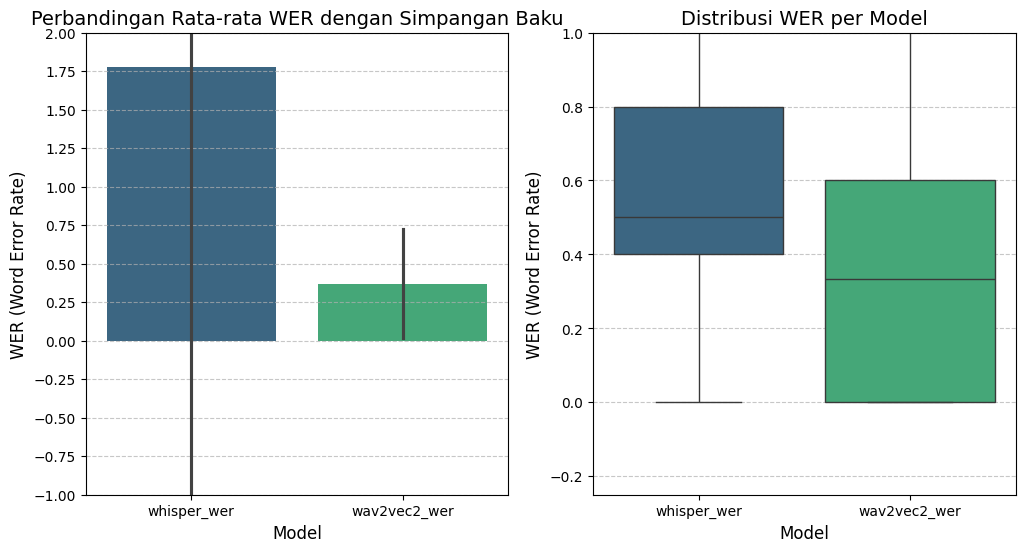

In [ ]:
import matplotlib.ticker as ticker
# Statistik WER
print("Menghitung statistik WER...")
wer_stats = df_long.groupby('model')['wer'].agg(['mean', 'std']).reset_index()
wer_stats.columns = ['model', 'WER_mean', 'WER_std']
print(wer_stats)
print("-" * 50)

plt.figure(figsize=(12, 6))

# Bar Chart WER
plt.subplot(1, 2, 1)
sns.barplot(x='model', y='wer', data=df_long, estimator=np.mean,
            errorbar='sd', # Mengganti 'ci' dengan 'errorbar'
            palette='viridis',
            legend=False) # Menambahkan legend=False
plt.title('Perbandingan Rata-rata WER dengan Simpangan Baku', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('WER (Word Error Rate)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.25))  # <- ini
plt.ylim(-1, 2)  # atur batas maksimal jika perlu

# Boxplot WER
plt.subplot(1, 2, 2)
sns.boxplot(x='model', y='wer', data=df_long, palette='viridis', legend=False)
plt.title('Distribusi WER per Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('WER (Word Error Rate)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.20))  # <- ini juga
plt.ylim(-0.25, 1)  # atur batas maksimal jika perlu


### Heatmap Performa Model

Membuat Heatmap performa model...


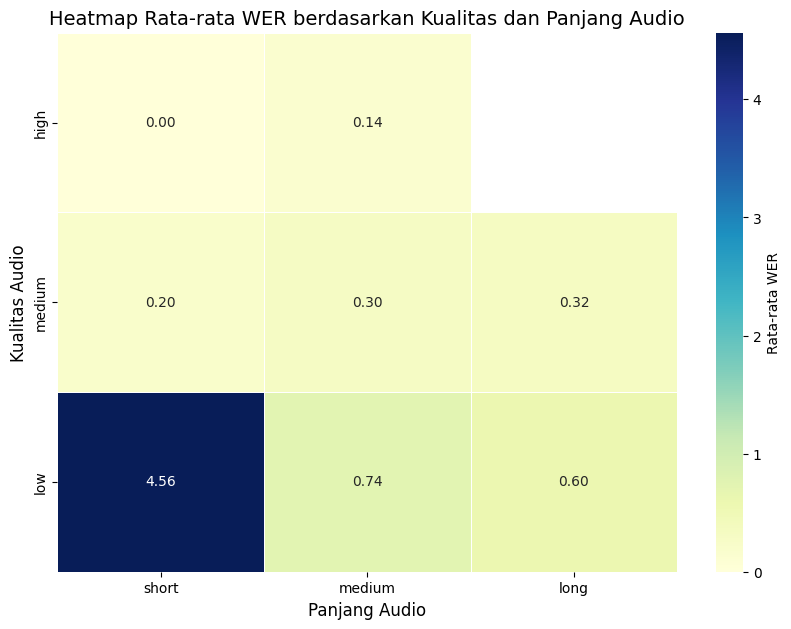

In [ ]:
# --- 3. Heatmap Performa Model berdasarkan Panjang Input Audio dan Kualitas Audio ---

print("Membuat Heatmap performa model...")

heatmap_data = df_long.pivot_table(
    index='audio_quality',
    columns='audio_length',
    values='wer',
    aggfunc='mean'
)

quality_order = ['high', 'medium', 'low']
length_order = ['short', 'medium', 'long']
heatmap_data = heatmap_data.reindex(index=quality_order, columns=length_order)

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Rata-rata WER'})
plt.title('Heatmap Rata-rata WER berdasarkan Kualitas dan Panjang Audio', fontsize=14)
plt.xlabel('Panjang Audio', fontsize=12)
plt.ylabel('Kualitas Audio', fontsize=12)
plt.show()

print("\n" + "=" * 50 + "\n")

### perbandingan Kecepatan Inferensi dan Resource Usage

In [ ]:
# --- 4. Tabel Perbandingan Kecepatan Inferensi dan Resource Usage ---

print("Membuat tabel perbandingan kecepatan inferensi dan penggunaan sumber daya...")

df_evaluation = pd.DataFrame(eval_results)

# Ubah ke long format untuk agregasi performa
df_long = pd.DataFrame({
    'model': ['Whisper'] * len(df_evaluation) + ['Wav2Vec2'] * len(df_evaluation),
    'inference_speed': df_evaluation['whisper_time'].tolist() + df_evaluation['wav2vec2_time'].tolist(),
    'cpu_usage': df_evaluation['whisper_cpu'].tolist() + df_evaluation['wav2vec2_cpu'].tolist(),
    'memory_usage': df_evaluation['whisper_mem'].tolist() + df_evaluation['wav2vec2_mem'].tolist(),
})

# Analisis perbandingan
resource_comparison = df_long.groupby('model').agg(
    Avg_Inference_Speed_sec=('inference_speed', 'mean'),
    Avg_CPU_Usage_percent=('cpu_usage', 'mean'),
    Avg_Memory_Usage_MB=('memory_usage', 'mean')
).reset_index()

print(resource_comparison.round(2).to_string(index=False))

Membuat tabel perbandingan kecepatan inferensi dan penggunaan sumber daya...
   model  Avg_Inference_Speed_sec  Avg_CPU_Usage_percent  Avg_Memory_Usage_MB
Wav2Vec2                     0.07                 -61.45                  0.0
 Whisper                     0.69                 -65.52                  0.0


# menyimpan model

In [ ]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, AutoModelForCTC, Wav2Vec2Processor
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Buat direktori tujuan di Google Drive
base_path = "/content/drive/MyDrive/skripsi ryan/asr_models"
os.makedirs(base_path, exist_ok=True)

# === Whisper ===
# whisper_model.save_pretrained(os.path.join(base_path, "whisper_model"))
# whisper_proc.save_pretrained(os.path.join(base_path, "whisper_processor"))


# Ambil model, tokenizer, dan feature extractor dari pipeline
whisper_model = whisper_pipe.model
whisper_tokenizer = whisper_pipe.tokenizer
whisper_feature_extractor = whisper_pipe.feature_extractor

# Simpan ke direktori masing-masing
whisper_model.save_pretrained(os.path.join(base_path, "whisper_model"))
whisper_tokenizer.save_pretrained(os.path.join(base_path, "whisper_processor"))
whisper_feature_extractor.save_pretrained(os.path.join(base_path, "whisper_processor"))

# === Wav2Vec2 ===
w2v2_model.save_pretrained(os.path.join(base_path, "wav2vec2_model"))
w2v2_proc.save_pretrained(os.path.join(base_path, "wav2vec2_processor"))

print(f"✅ Models saved successfully to Google Drive in folder: {base_path}")
